# Empirical Project

- Paola Antonicoli
- Michelangelo Saveriano

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
import warnings
from tqdm.notebook import tqdm
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["figure.dpi"] = 150
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%cd /content/drive/MyDrive/DDE
from functions import pkl_load, pkl_save, aggregate_signal, filter_dataframe_keeping_dates, fill_missing_data

/content/drive/MyDrive/DDE


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def forecast(Y, forecast_horizon = 1, min_samples = 48, max_lags = 12, 
             n_output=2, return_model=True, print_avg_lag=True):
  # Y.index = pd.DatetimeIndex(dates_from_str(Y.index))

  N = len(Y) - forecast_horizon

  forecasts = []
  forecasts_error = []
  lags = []

  for i in range(min_samples, N):
    Y_train = Y.iloc[:i]
    Y_true = Y.values[i]

    # Fit
    model = VAR(endog = Y_train)
    model.select_order(max_lags)
    results = model.fit(maxlags=max_lags, ic='aic')

    # Forecast next time instant
    lag_order = results.k_ar
    lags.append(lag_order)
    Y_test = Y_train.values[-lag_order:]
    forecast = results.forecast(Y_test, 1)
    forecasts.append(forecast)
    forecasts_error.append((Y_true - forecast) ** 2)

  if print_avg_lag:
    print(f'Avg. Lag: {np.mean(lags)}')
  forecasts = np.vstack(forecasts)
  forecasts_error = np.vstack(forecasts_error)

  # df_forecast_error = pd.DataFrame(forecasts_error, columns=np.array(['Forecasted-Error-']) + Y.columns)
  # df_forecast_error.index = Y.iloc[min_samples:N].index

  df_forecast = pd.DataFrame(forecasts, columns=Y.columns)
  df_forecast.index = Y.iloc[min_samples:N].index
  if return_model:
    return df_forecast.iloc[:, :n_output], results#, df_forecast_error
  return df_forecast.iloc[:, :n_output] #, df_forecast_error

In [ ]:
def load_daily_vader(df, df_day, filt_series):
  df_signal = pkl_load('vader_scores')[['compound']]
  df_signal['tweet_dt'] = df['tweet_dt']
  df_signal = filter_dataframe_keeping_dates(df_signal, filt_series, df_day, {'compound': 0})
  daily_signal = aggregate_signal(df_signal.drop(columns='tweet_dt').values, 
                                  df_signal[['tweet_dt']], 'tweet_dt')
  return daily_signal
  
def reshape_sparse_array(x):
  if hasattr(x, 'toarray'):
    return x.toarray()[0]
  return np.zeros(155)

# df_signal_or = pd.DataFrame({'tf': list(pkl_load('tf_scores'))})
df_signal_or = None

def load_daily_tf(df, df_day, filt_series, df_signal_or=df_signal_or):
  if df_signal_or is None:
    signal = pkl_load('tf_scores')
    df_signal = pd.DataFrame({'tf': list(signal)})
  df_signal = df_signal_or.copy()
  df_signal['tweet_dt'] = df['tweet_dt']
  df_signal = filter_dataframe_keeping_dates(df_signal, filt_series, 
                                             df_day, {'tf': 0})
  daily_signal = aggregate_signal(df_signal.drop(columns='tweet_dt').values, 
                                  df_signal[['tweet_dt']], 'tweet_dt')
  daily_signal = np.vstack(map(reshape_sparse_array, daily_signal[:, 0]))
  return daily_signal

def load_daily_bert(filename):
  return pkl_load(filename)

def load_data(df, dataset_name, index, df_day, max_date = None, n_comp = 1):
  # return the specified index dataframe e.g. df_vader, df_tf, df_bert (date must be index)
  dict_dataset_names = {'Original': '',
                      'Professional': '_P',
                      'NoBot': '_NB',
                      'Professional-NoBot': '_P_NB'}

  dict_index_filename = {
      'Vader': 'vader_scores',
      'TF': 'tf_scores',
      'Bert': 'daily_bert'
  }

  # Select tweets to drop according to dataset_name
  filt_series = np.repeat(True, len(df))
  if 'NoBot' in dataset_name:
    filt_series = filt_series & (~df['bot'])
  if 'Professional' in dataset_name:
    filt_series = filt_series & df['professional']

  # Extract the daily signal
  if index == 'Vader':
    daily_signal = load_daily_vader(df, df_day, filt_series)
  elif index == 'TF':
    daily_signal = load_daily_tf(df, df_day, filt_series)
  elif index == 'Bert':
    daily_signal = load_daily_bert('daily_bert' + dict_dataset_names[dataset_name])
  elif index == 'ITI':
    daily_signal = np.hstack([load_daily_vader(df, df_day, filt_series), 
                              load_daily_tf(df, df_day, filt_series),
                              load_daily_bert('daily_bert' + dict_dataset_names[dataset_name])])
  
  # Extract the principal component
  train_index = df_day[df_day.year < max_date].index
  pca = PCA(n_components = n_comp, whiten=True)
  pca.fit(daily_signal[train_index])
  daily_signal_pc =  pca.transform(daily_signal)

  # Compute monthly average
  month_signal = aggregate_signal(daily_signal_pc, df_day, 'year_month')
  df_signal = pd.DataFrame(month_signal, columns=[dataset_name + '_' + index])
  df_signal['DATE'] = df_day.sort_values('year_month')['year_month'].unique() + '-01'
  return df_signal.set_index('DATE').shift(1).dropna().reset_index()

def merge_inflation_index(df_inflation, df_index):
  df_index = fill_missing_data(df_index, df_inflation).set_index('DATE')
  return pd.concat([df_inflation, df_index], axis = 1)

# Compute signals

In [ ]:
df = pkl_load('df')
df_inflation = pkl_load('df_inflation')
df_day = pkl_load('df_day')

In [ ]:
dataset_names = ['Original', 'Professional', 'NoBot', 'Professional-NoBot']
indices = ['Vader', 'TF', 'Bert', 'ITI'] # Inflation Text Index


In [ ]:
# Forecasting Parameters
forecast_horizon = 1 
min_samples = 48
max_lags = 3
max_train_date = (df_day.sort_values('year_month')['year_month'].unique() + '-01')[min_samples-1]
max_train_date

'2018-05-01'

In [ ]:
# dfs_signal = []
# for dataset_name in dataset_names:
#   for index in indices:
#     print(dataset_name, index)
#     dfs_signal.append(load_data(df, dataset_name, index, df_day, max_date=max_train_date))
# df_signals = pd.concat(dfs_signal[:1] + list(map(lambda x: x.iloc[:, 1:], dfs_signal[1:])), axis=1)
# pkl_save('df_signals', df_signals)
# df_signals

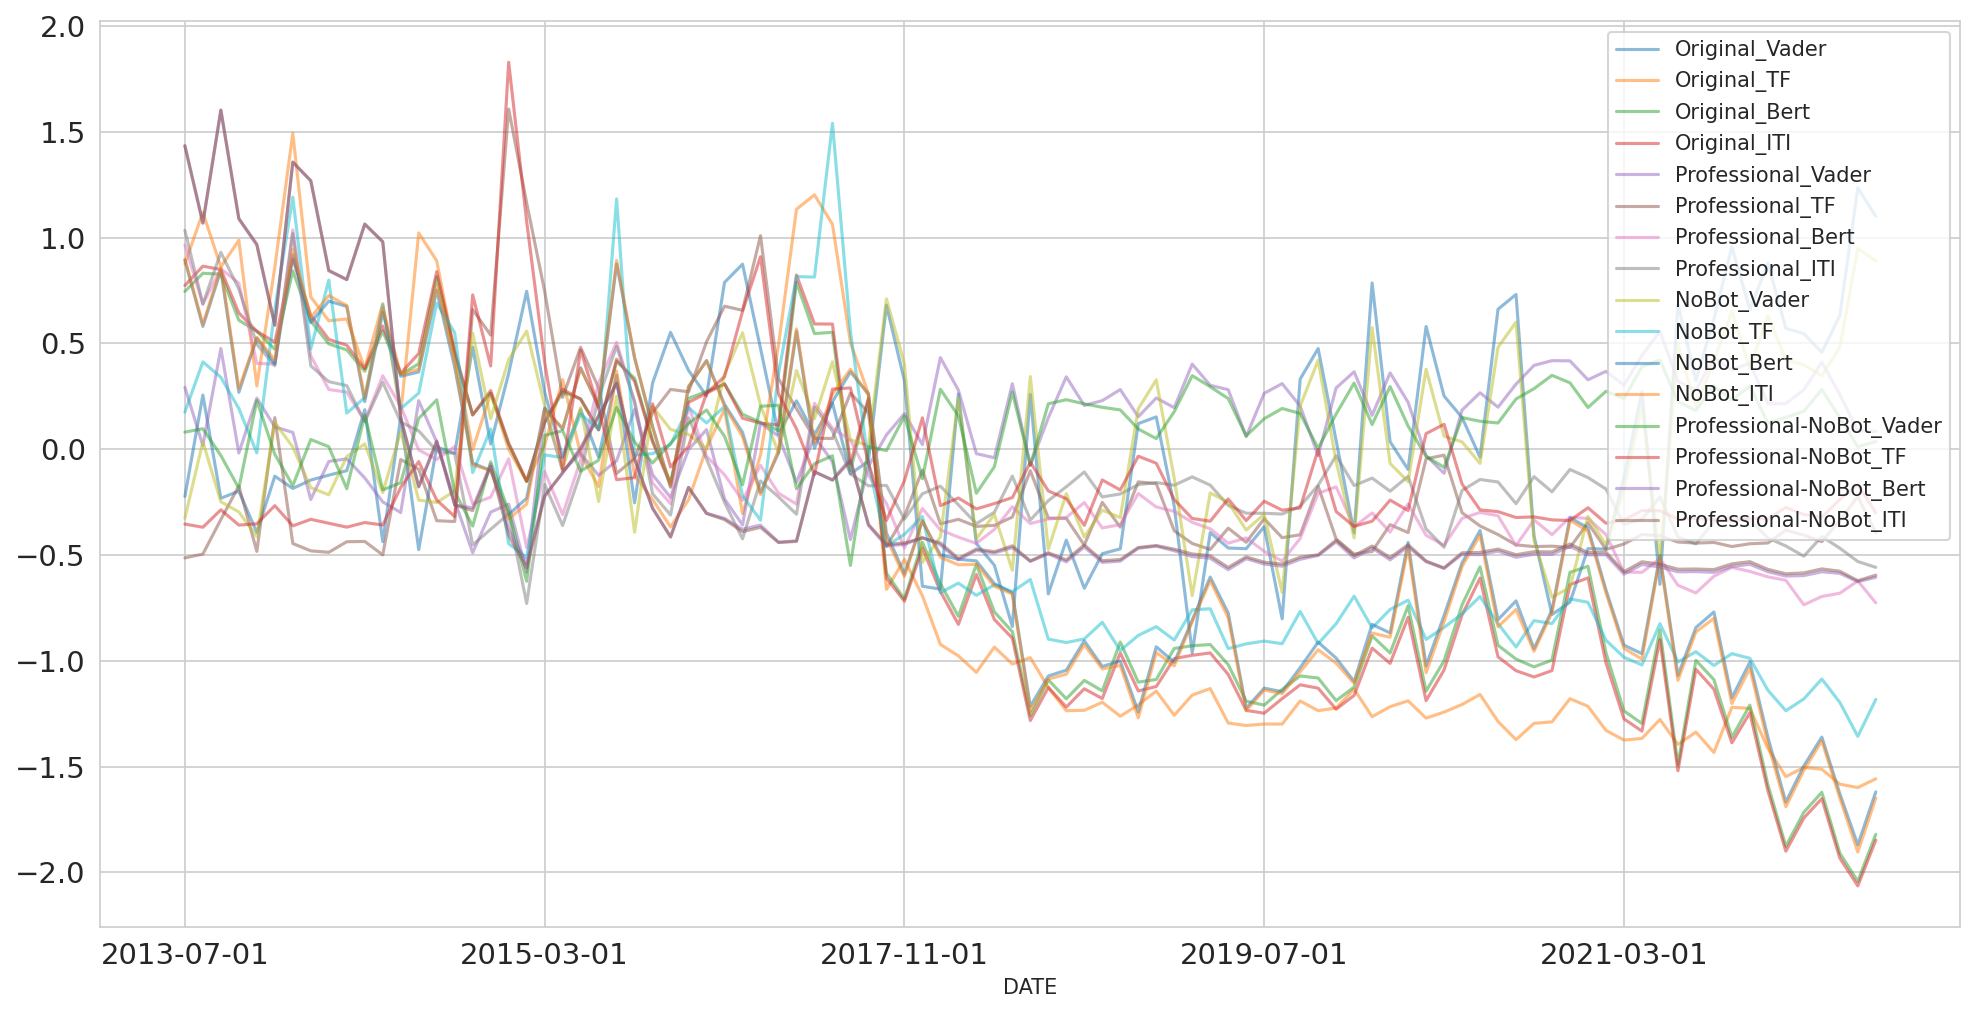

In [ ]:
df_signals = pkl_load('df_signals')
df_signals.set_index('DATE').plot(alpha=.5)
plt.show()
# df_signals

In [ ]:
df_signals_melt = fill_missing_data(df_signals, df_inflation).melt('DATE')
df_signals_melt.columns = ['Date', 'Id', 'Value']
df_signals_melt['Date'] = pd.to_datetime(df_signals_melt['Date'])
df_signals_melt['Dataset'] = df_signals_melt['Id'].apply(lambda x: x.split('_')[0])
df_signals_melt['Index'] = df_signals_melt['Id'].apply(lambda x: x.split('_')[-1])
df_signals_melt.head()

Date              Id     Value   Dataset  Index
0 2013-07-01  Original_Vader -0.223847  Original  Vader
1 2013-08-01  Original_Vader  0.255558  Original  Vader
2 2013-09-01  Original_Vader -0.232238  Original  Vader
3 2013-10-01  Original_Vader -0.198143  Original  Vader
4 2013-11-01  Original_Vader -0.393523  Original  Vader

## Plot signals

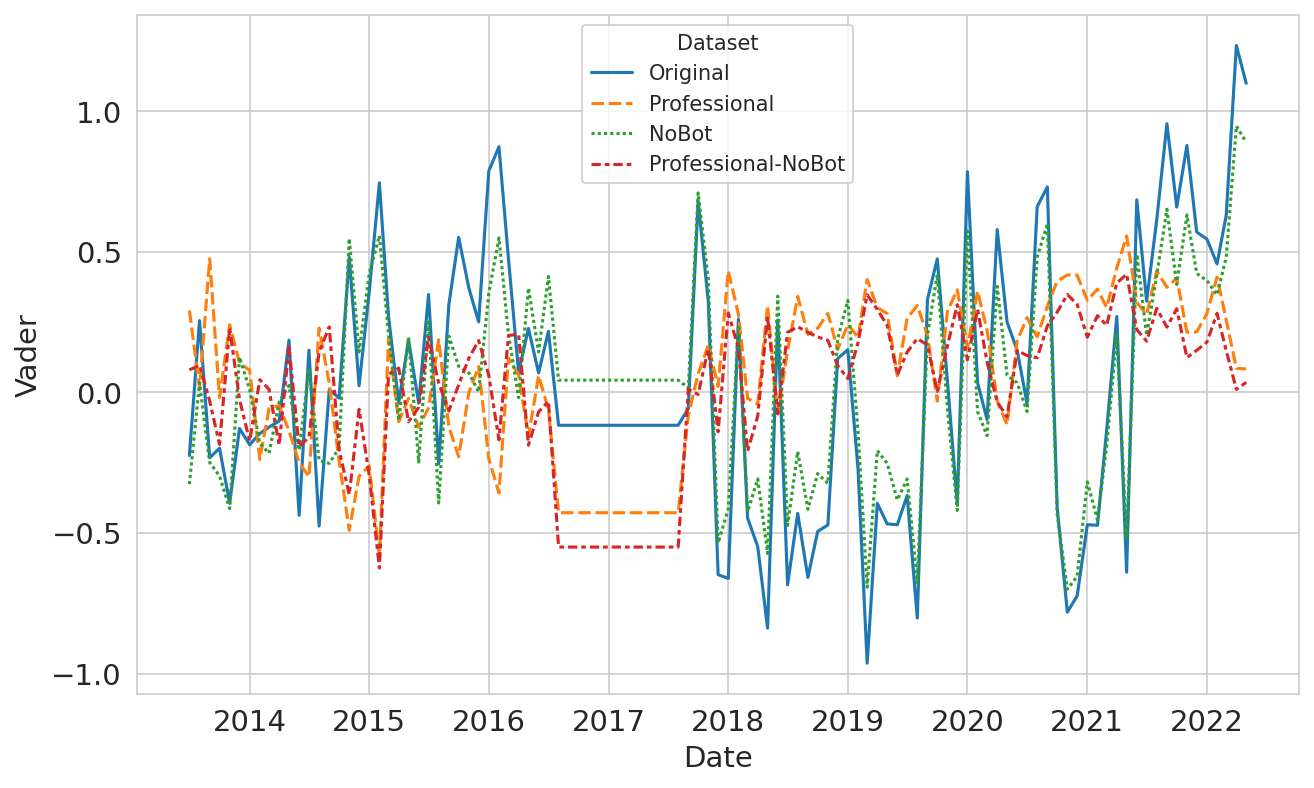

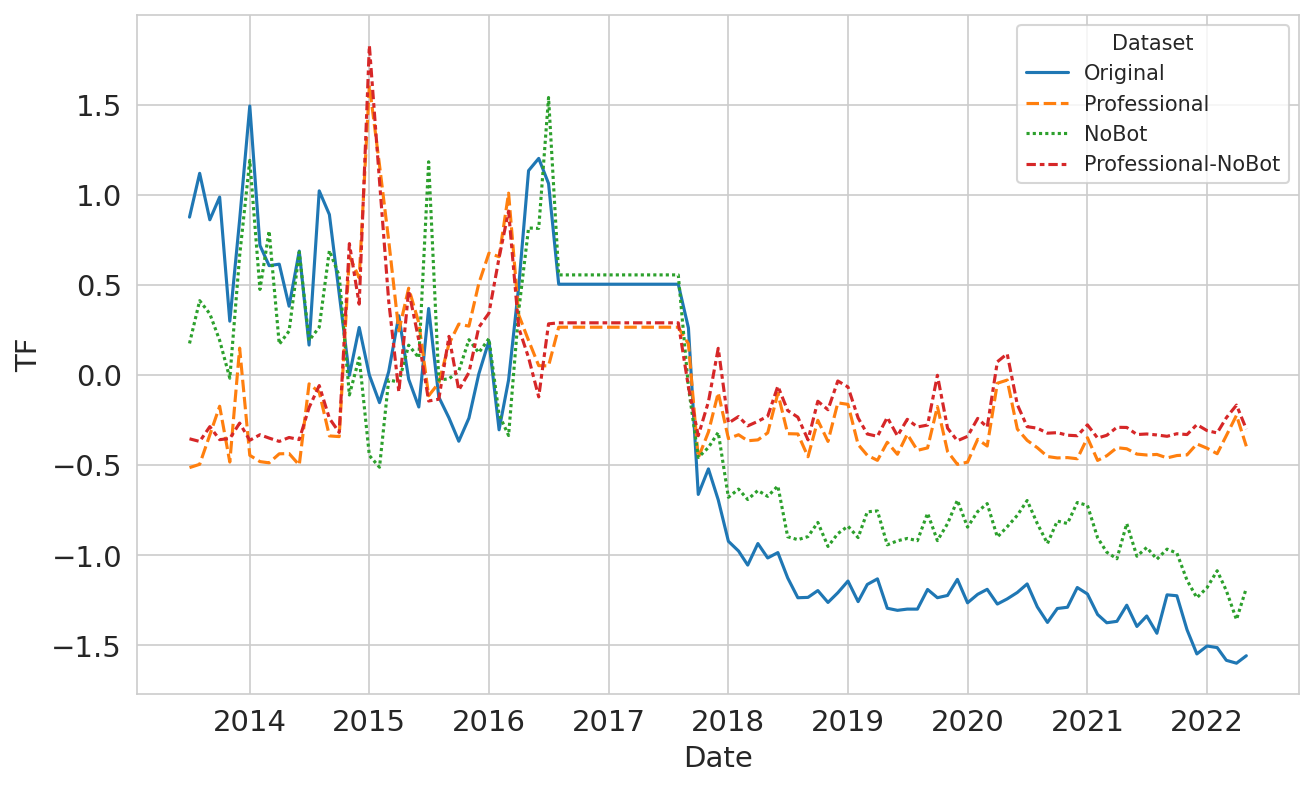

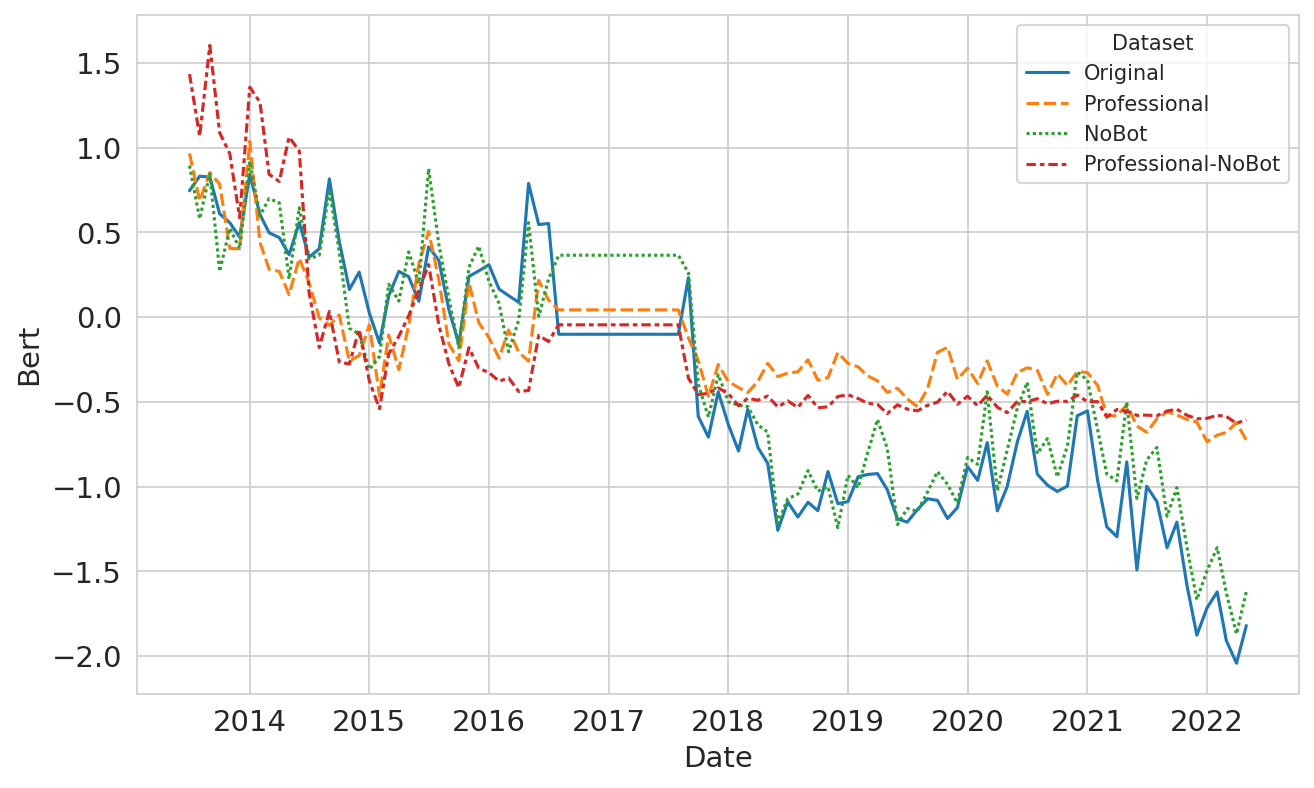

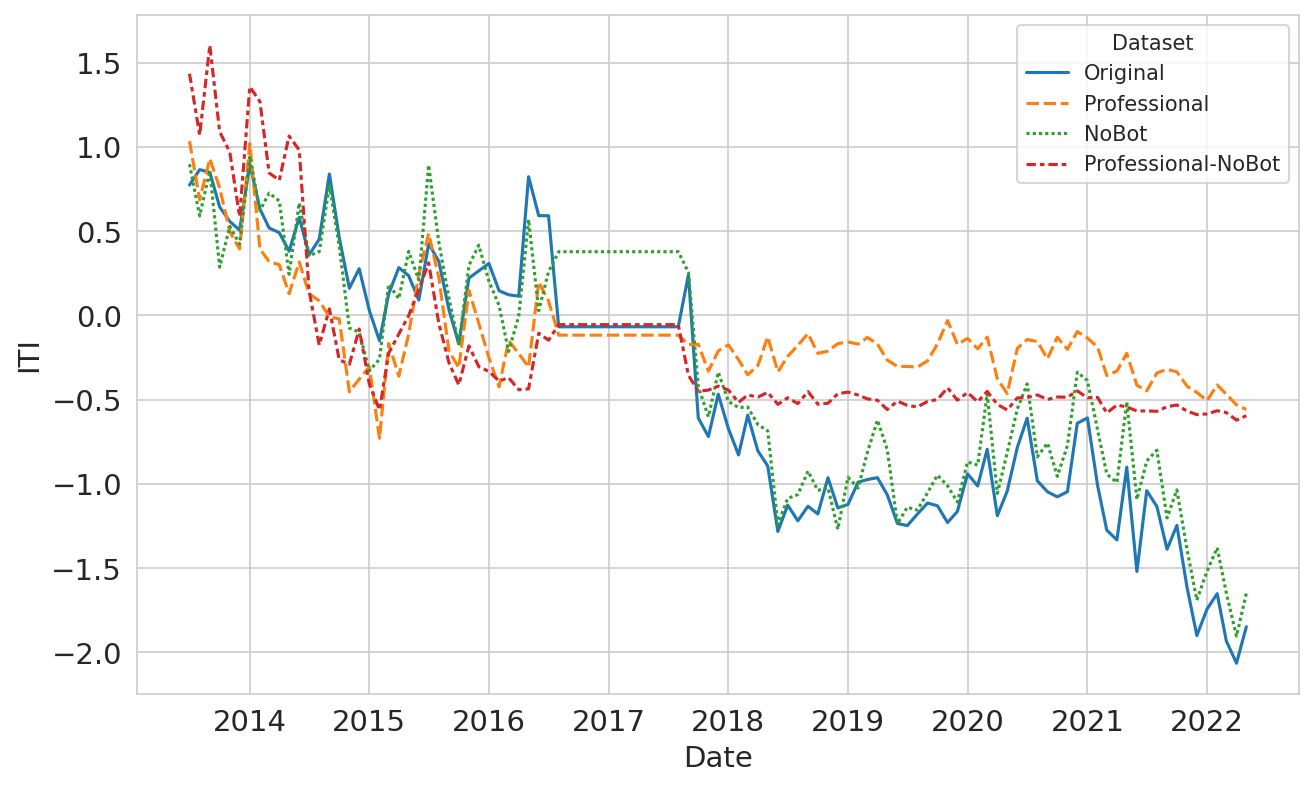

In [ ]:
for index in df_signals_melt['Index'].unique():
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_signals_melt[df_signals_melt['Index'] == index], x='Date', y='Value', hue='Dataset', style='Dataset')
  plt.xlabel('Date', fontsize=14)
  plt.ylabel(index, fontsize=14)
  plt.show()

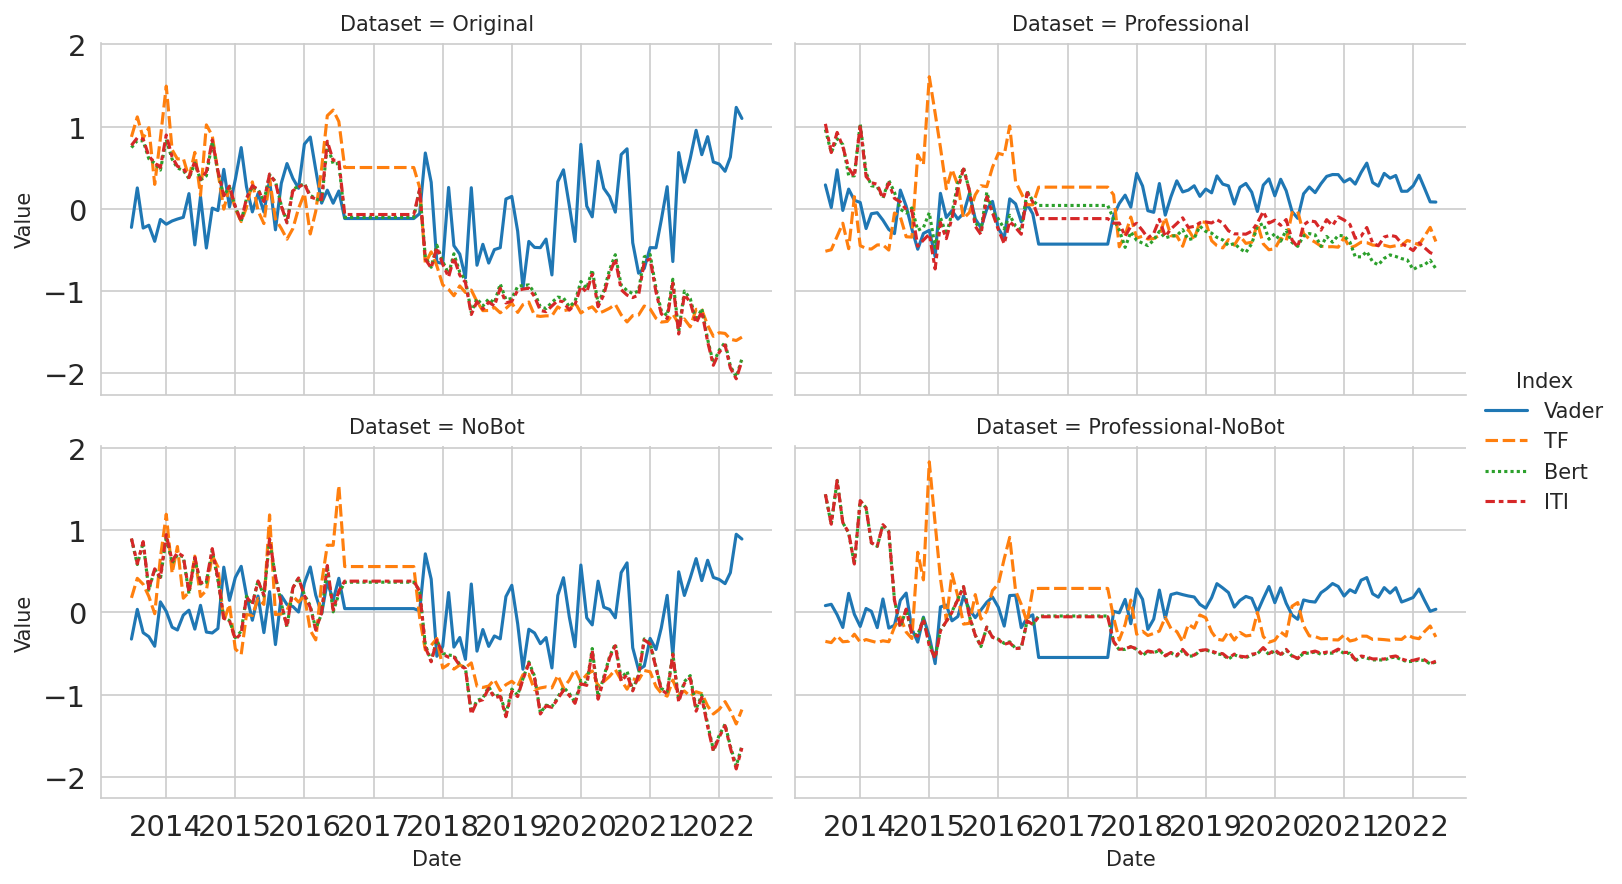

In [ ]:
sns.relplot(data=df_signals_melt, x='Date', y='Value', hue='Index', style='Index', col='Dataset', col_wrap=2, aspect=5/3, height=3, kind='line')
plt.show()

# Perform Forecast

In [ ]:
list_forecasts = []
list_forecasts_errors = []
models = dict()

# Benchmark
# Forecast infation
print('Forecast Model - ', end='')
df_forecast, model = forecast(df_inflation, forecast_horizon = forecast_horizon, min_samples = min_samples, max_lags = max_lags)

# Evaluate Errors
df_forecast_error = (df_inflation.loc[df_forecast.index] - df_forecast.values)**2

# Save Forecast
df_forecast.columns = 'Benchmark-' + df_forecast.columns
list_forecasts.append(df_forecast)

# Save Errors
df_forecast_error.columns = 'Benchmark-' + df_forecast_error.columns
list_forecasts_errors.append(df_forecast_error)

# Save the last model
models['Benchmark'] = model

# For each index computed
for index_name in tqdm(df_signals.columns[1:]):
  # Compute Y
  Y = merge_inflation_index(df_inflation, df_signals[['DATE', index_name]])

  # Forecast infation
  print(f'{index_name} - ', end='')
  df_forecast, model = forecast(Y, forecast_horizon = forecast_horizon, min_samples = min_samples, max_lags = max_lags)

  # Evaluate Errors
  df_forecast_error = (df_inflation.loc[df_forecast.index] - df_forecast.values)**2

  # Save Forecast
  df_forecast.columns = index_name + '-' + df_forecast.columns
  list_forecasts.append(df_forecast)
  
  # Save Errors
  df_forecast_error.columns = index_name + '-' + df_forecast_error.columns
  list_forecasts_errors.append(df_forecast_error)

  # Save the last model
  models[index_name] = model

# Base Model
# Forecast infation
df_forecast = df_inflation.shift(1).loc[df_forecast.index]

# Evaluate Errors
df_forecast_error = (df_inflation.loc[df_forecast.index] - df_forecast.values)**2

# Save Forecast
df_forecast.columns = 'Base-' + df_forecast.columns
list_forecasts.append(df_forecast)

# Save Errors
df_forecast_error.columns = 'Base-' + df_forecast_error.columns
list_forecasts_errors.append(df_forecast_error)

df_forecasts = pd.concat(list_forecasts, axis=1)
df_forecasts_errors = pd.concat(list_forecasts_errors, axis=1)

Forecast Model - Avg. Lag: 2.9655172413793105


  0%|          | 0/16 [00:00<?, ?it/s]

Original_Vader - Avg. Lag: 2.206896551724138
Original_TF - Avg. Lag: 1.3793103448275863
Original_Bert - Avg. Lag: 1.9655172413793103
Original_ITI - Avg. Lag: 1.8620689655172413
Professional_Vader - Avg. Lag: 2.0689655172413794
Professional_TF - Avg. Lag: 2.396551724137931
Professional_Bert - Avg. Lag: 1.7413793103448276
Professional_ITI - Avg. Lag: 1.4310344827586208
NoBot_Vader - Avg. Lag: 2.5344827586206895
NoBot_TF - Avg. Lag: 1.396551724137931
NoBot_Bert - Avg. Lag: 2.0
NoBot_ITI - Avg. Lag: 1.9482758620689655
Professional-NoBot_Vader - Avg. Lag: 3.0
Professional-NoBot_TF - Avg. Lag: 1.9655172413793103
Professional-NoBot_Bert - Avg. Lag: 1.0
Professional-NoBot_ITI - Avg. Lag: 1.0


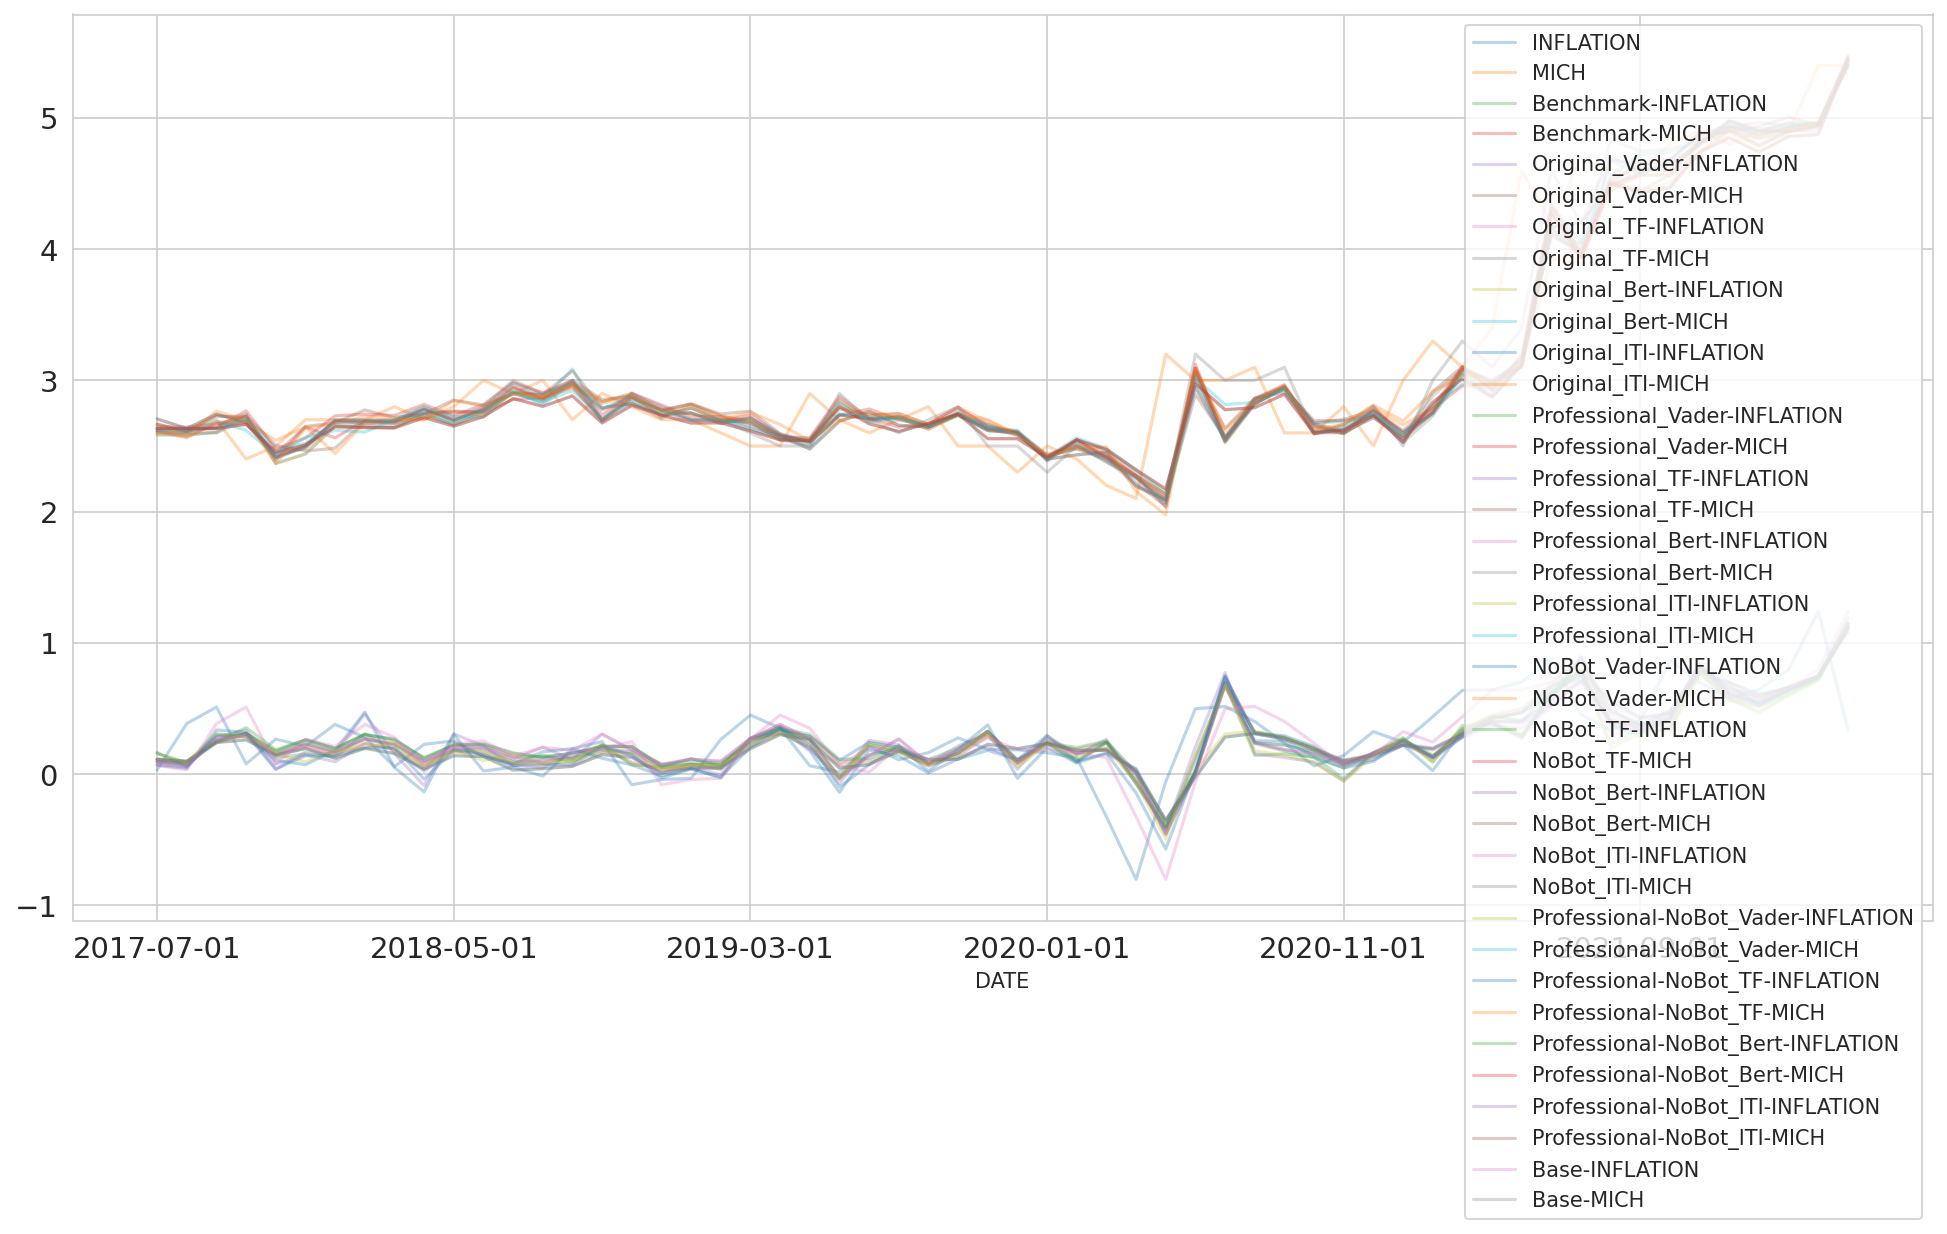

In [ ]:
pd.concat([df_inflation, df_forecasts], axis=1).dropna().plot(alpha=.3)

# Plot Results

## Plot Forecasts

In [ ]:
df_forecasts_melted = df_forecasts.reset_index().melt('DATE')
df_forecasts_melted.columns = ['DATE', 'Id', 'Value']
df_forecasts_melted['DATE'] = pd.to_datetime(df_forecasts_melted['DATE'])
df_forecasts_melted['InflationMeasure'] = df_forecasts_melted['Id'].apply(lambda x: x.split('-')[-1].title())
df_forecasts_melted['Index'] = df_forecasts_melted['Id'].apply(lambda x: '-'.join(x.split('-')[:-1]).split('_')[-1].title())
df_forecasts_melted['Dataset'] = df_forecasts_melted['Id'].apply(lambda x: '-'.join(x.split('-')[:-1]).split('_')[0].title())
df_forecasts_melted.head()

DATE                   Id     Value InflationMeasure      Index  \
0 2017-07-01  Benchmark-INFLATION  0.156239        Inflation  Benchmark   
1 2017-08-01  Benchmark-INFLATION  0.084790        Inflation  Benchmark   
2 2017-09-01  Benchmark-INFLATION  0.295290        Inflation  Benchmark   
3 2017-10-01  Benchmark-INFLATION  0.300851        Inflation  Benchmark   
4 2017-11-01  Benchmark-INFLATION  0.124274        Inflation  Benchmark   

     Dataset  
0  Benchmark  
1  Benchmark  
2  Benchmark  
3  Benchmark  
4  Benchmark

In [ ]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

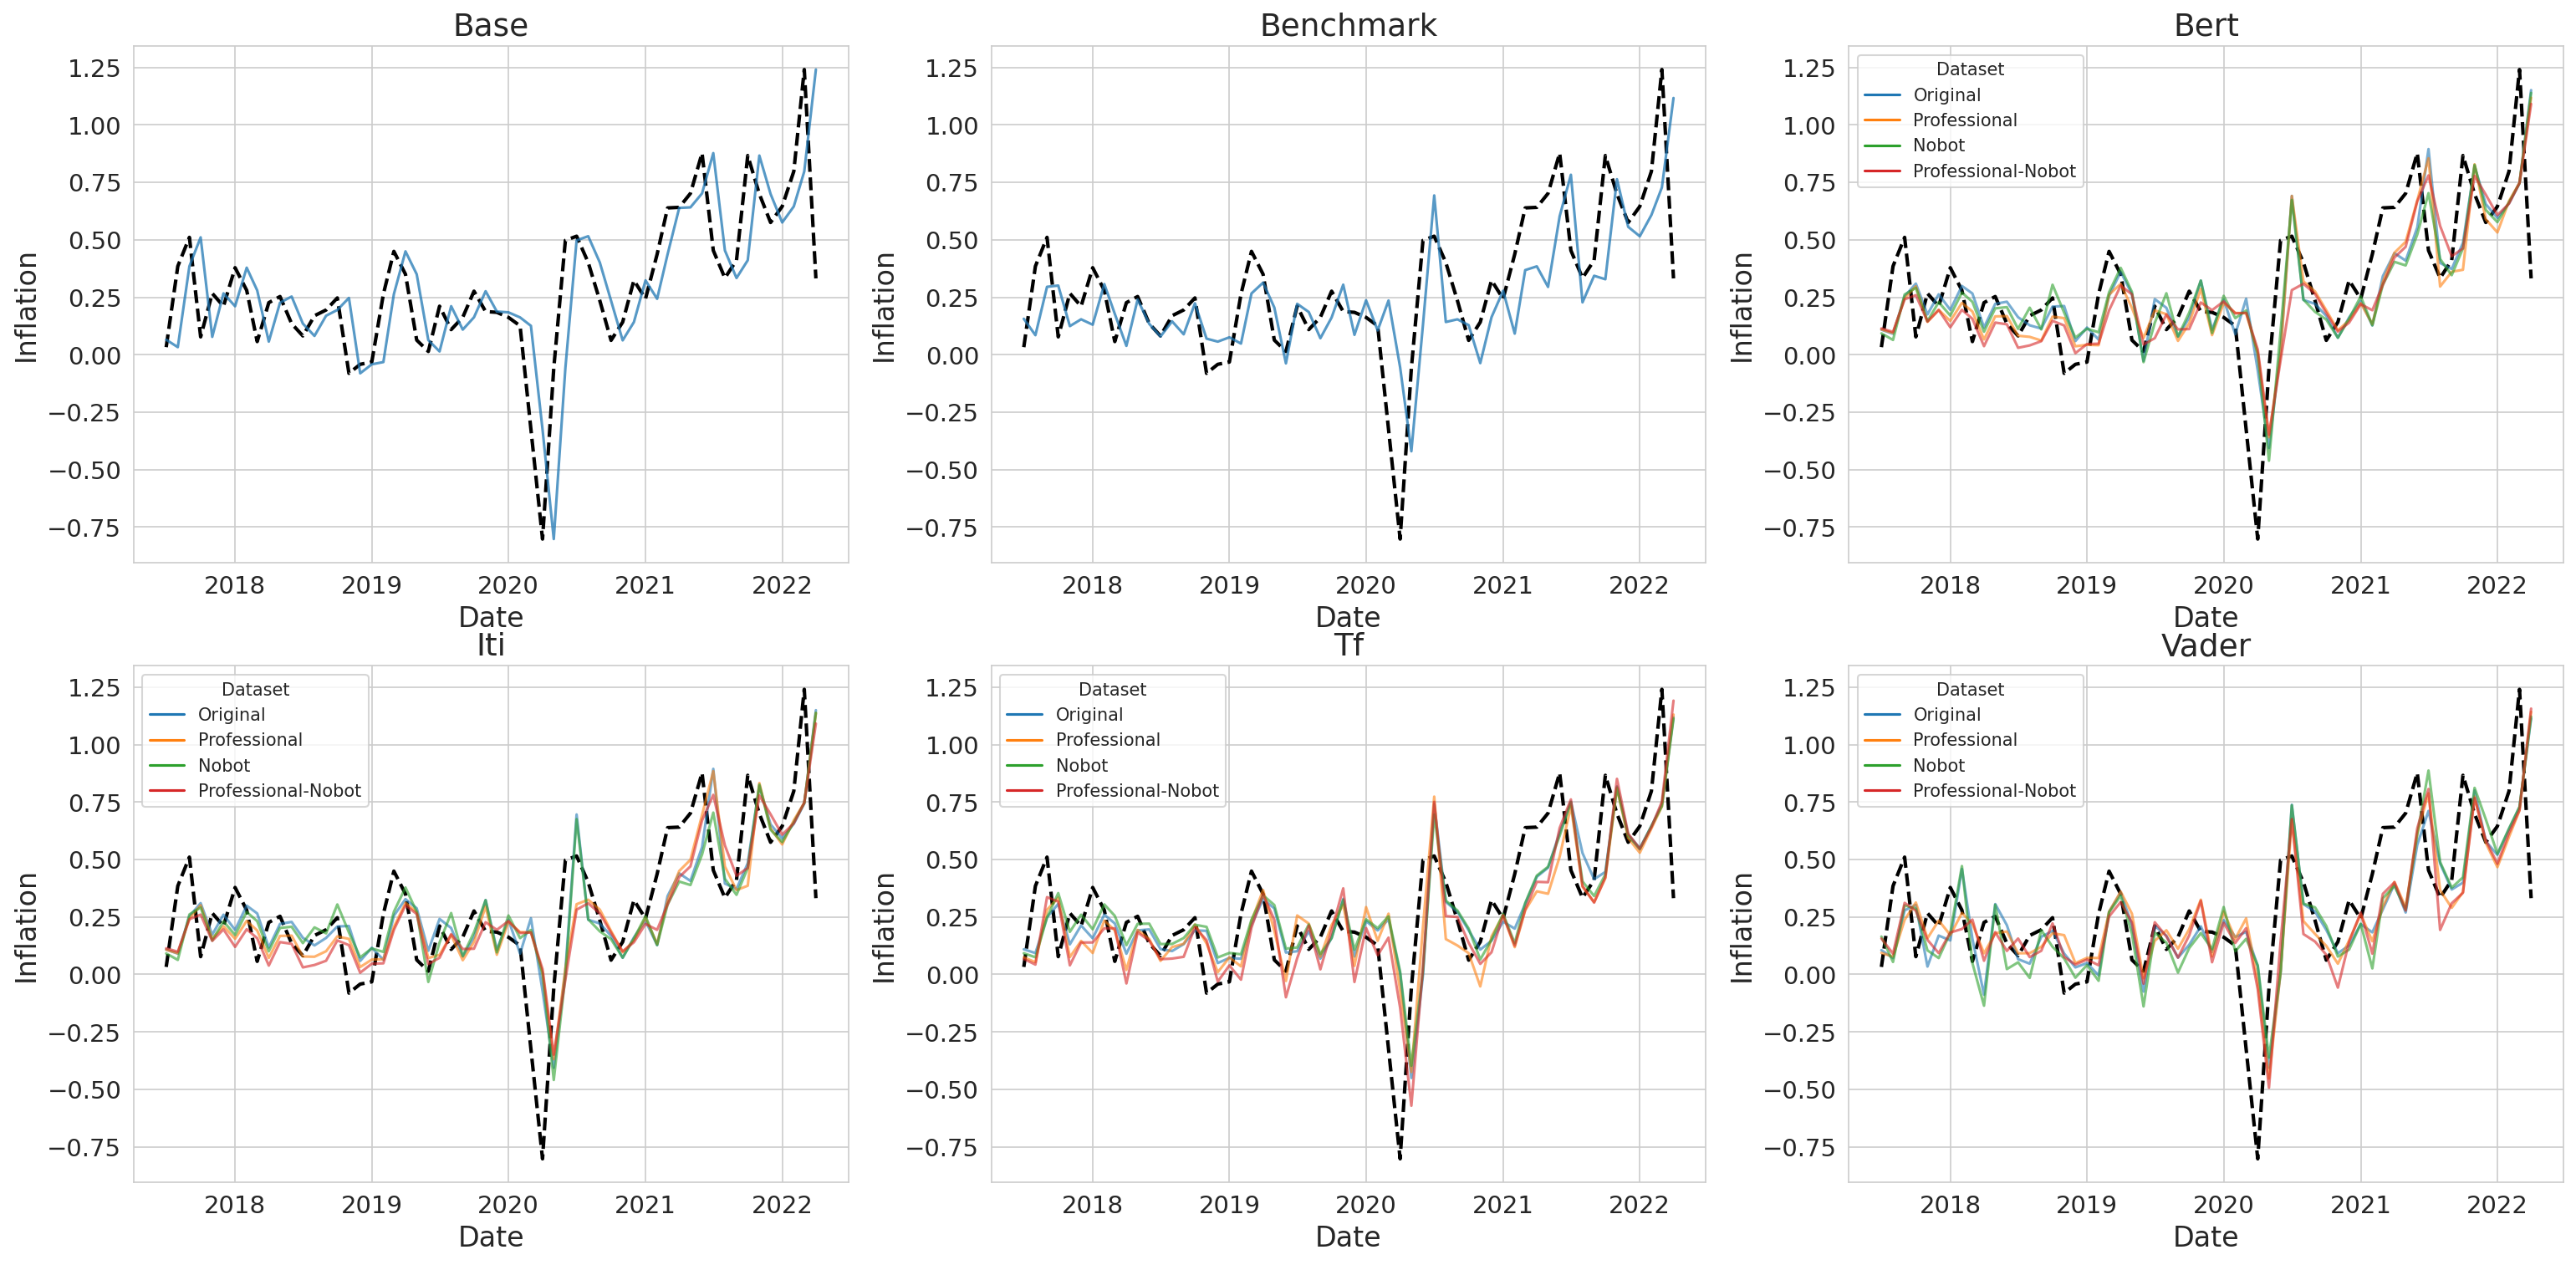

In [ ]:

inflation_measure = 'Inflation'
df_test_inflation = df_inflation.loc[df_forecast.index]
fig, axs = plt.subplots(2, df_forecasts_melted['Index'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
for i, index in enumerate(df_forecasts_melted.sort_values('Index')['Index'].unique()):
  axs[i].plot(pd.to_datetime(df_test_inflation.index), df_test_inflation[inflation_measure.upper()], '--', lw=2, c='black')
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(index, fontsize=18)
  if index == 'Base' or index == 'Benchmark':
     sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                        (df_forecasts_melted['Index'] == index)], 
                  x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                          (df_forecasts_melted['Index'] == index)], 
                 x='DATE', y='Value', hue='Dataset', ax=axs[i], alpha=.6)

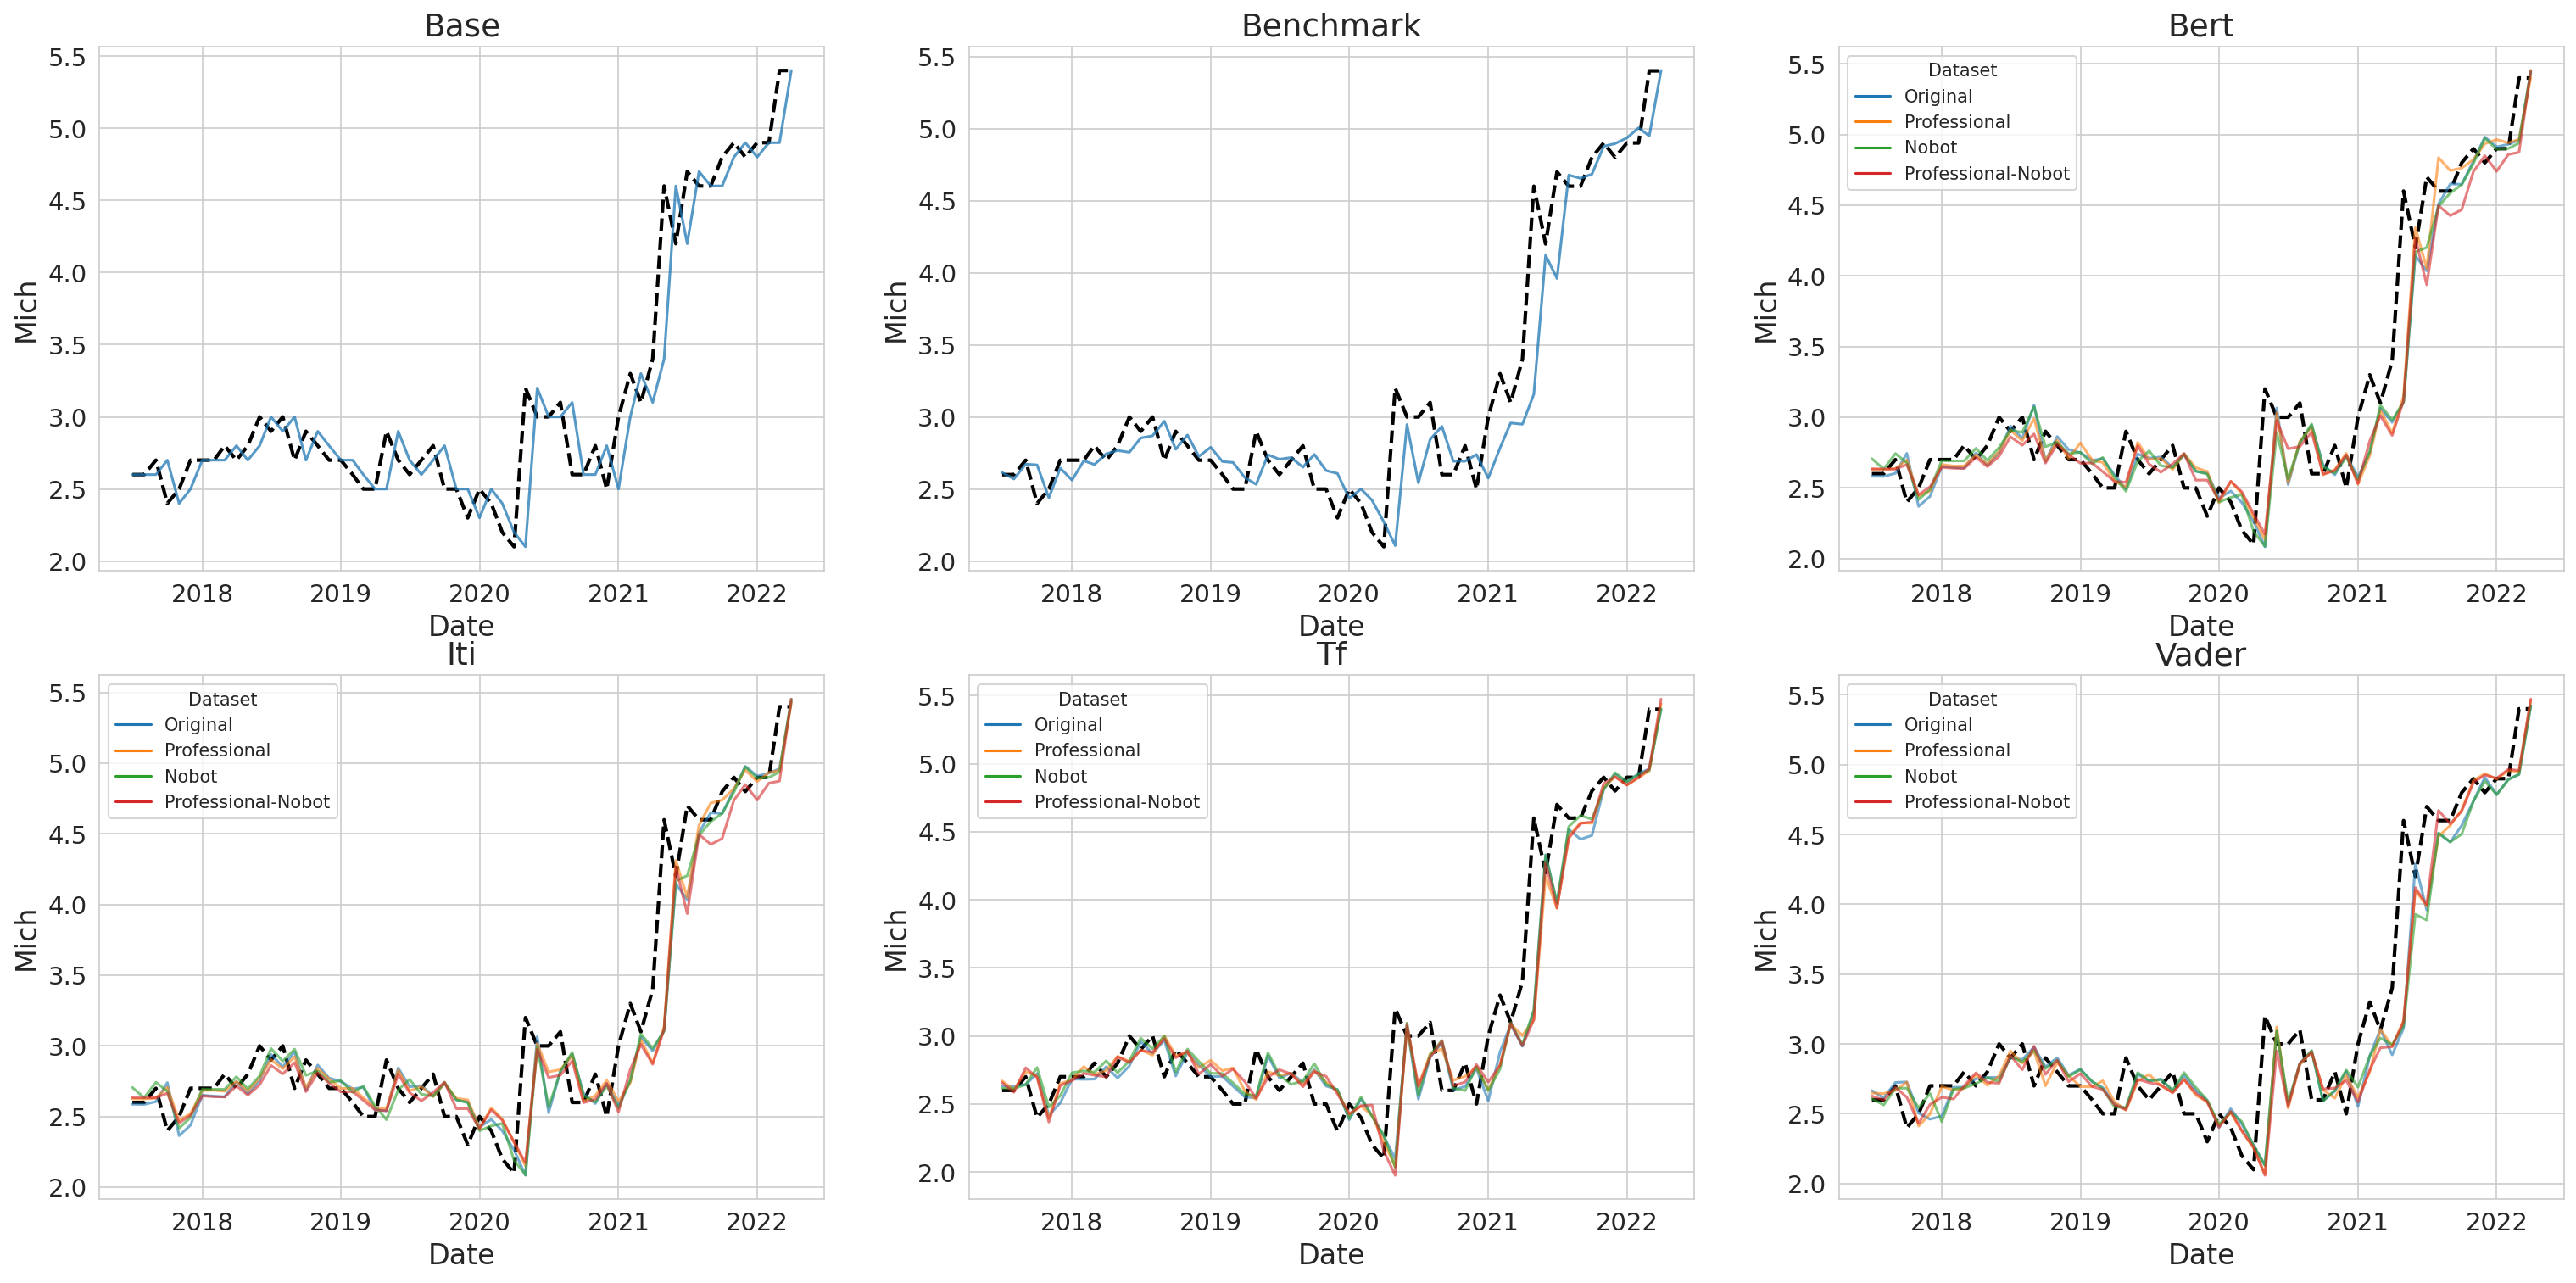

In [ ]:
inflation_measure = 'Mich'
df_test_inflation = df_inflation.loc[df_forecast.index]
fig, axs = plt.subplots(2, df_forecasts_melted['Index'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
for i, index in enumerate(df_forecasts_melted.sort_values('Index')['Index'].unique()):
  axs[i].plot(pd.to_datetime(df_test_inflation.index), df_test_inflation[inflation_measure.upper()], '--', lw=2, c='black')
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(index, fontsize=18)
  if index == 'Base' or index == 'Benchmark':
     sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                        (df_forecasts_melted['Index'] == index)], 
                  x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                          (df_forecasts_melted['Index'] == index)], 
                 x='DATE', y='Value', hue='Dataset', ax=axs[i], alpha=.6)

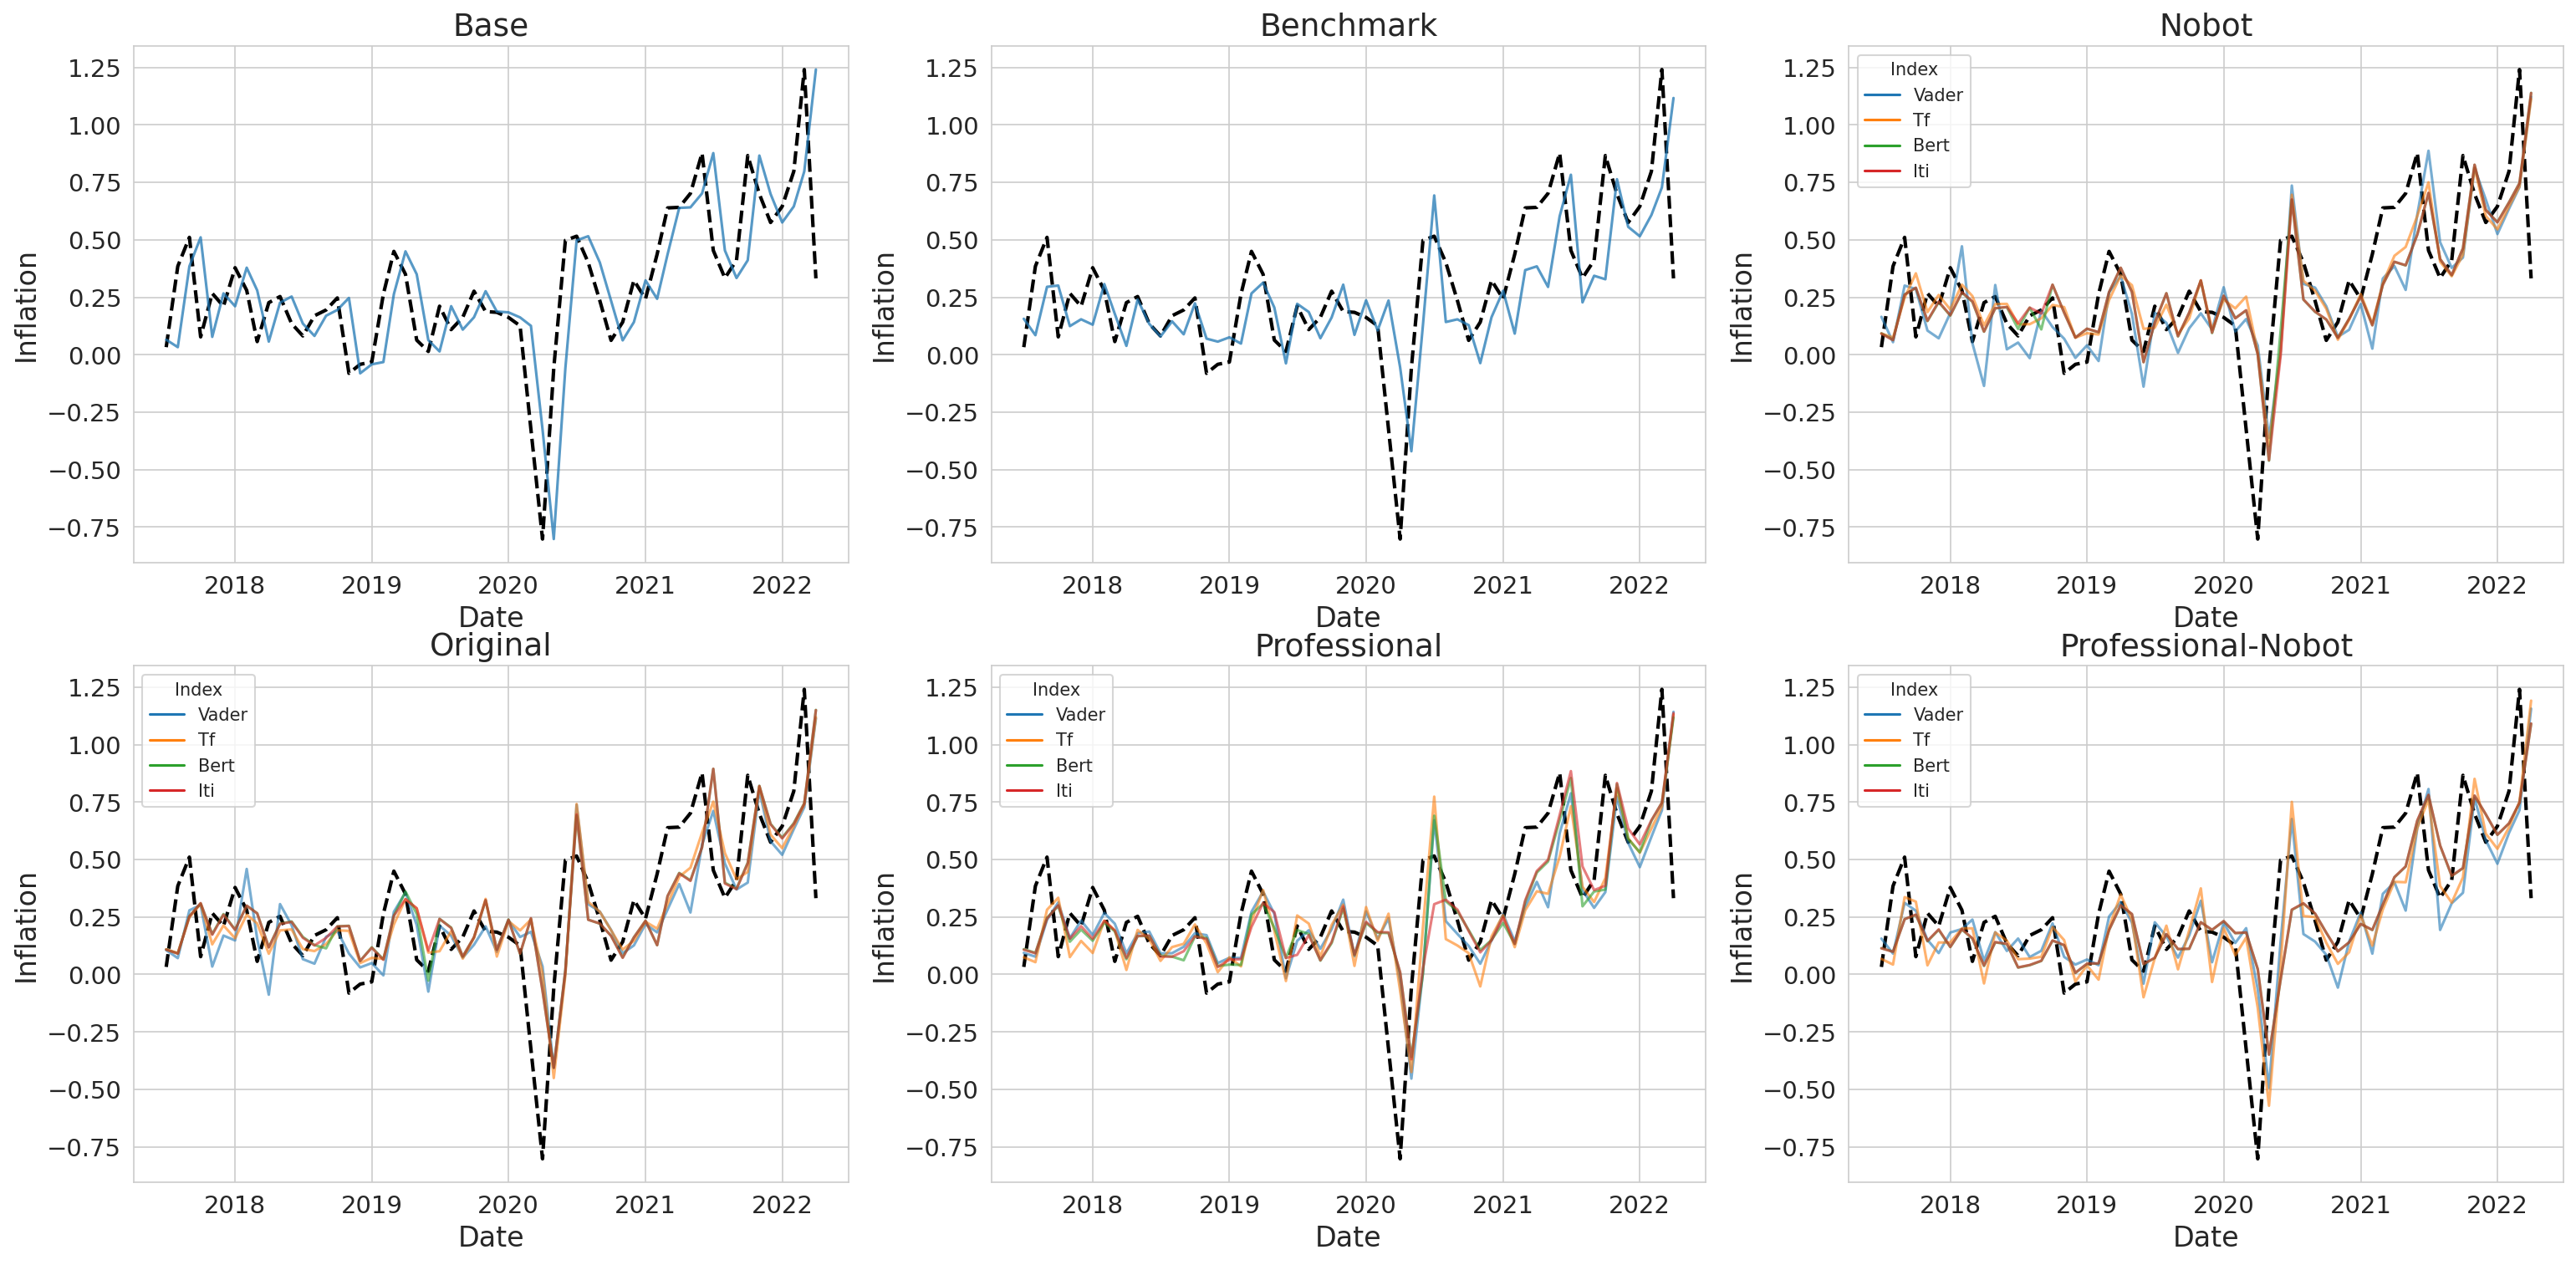

In [ ]:
inflation_measure = 'Inflation'
df_test_inflation = df_inflation.loc[df_forecast.index]
fig, axs = plt.subplots(2, df_forecasts_melted['Dataset'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
for i, dataset in enumerate(df_forecasts_melted.sort_values('Dataset')['Dataset'].unique()):
  axs[i].plot(pd.to_datetime(df_test_inflation.index), df_test_inflation[inflation_measure.upper()], '--', lw=2, c='black')
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(dataset, fontsize=18)
  if dataset == 'Base' or dataset == 'Benchmark':
    sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                          (df_forecasts_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                          (df_forecasts_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', hue='Index', ax=axs[i], alpha=.6)

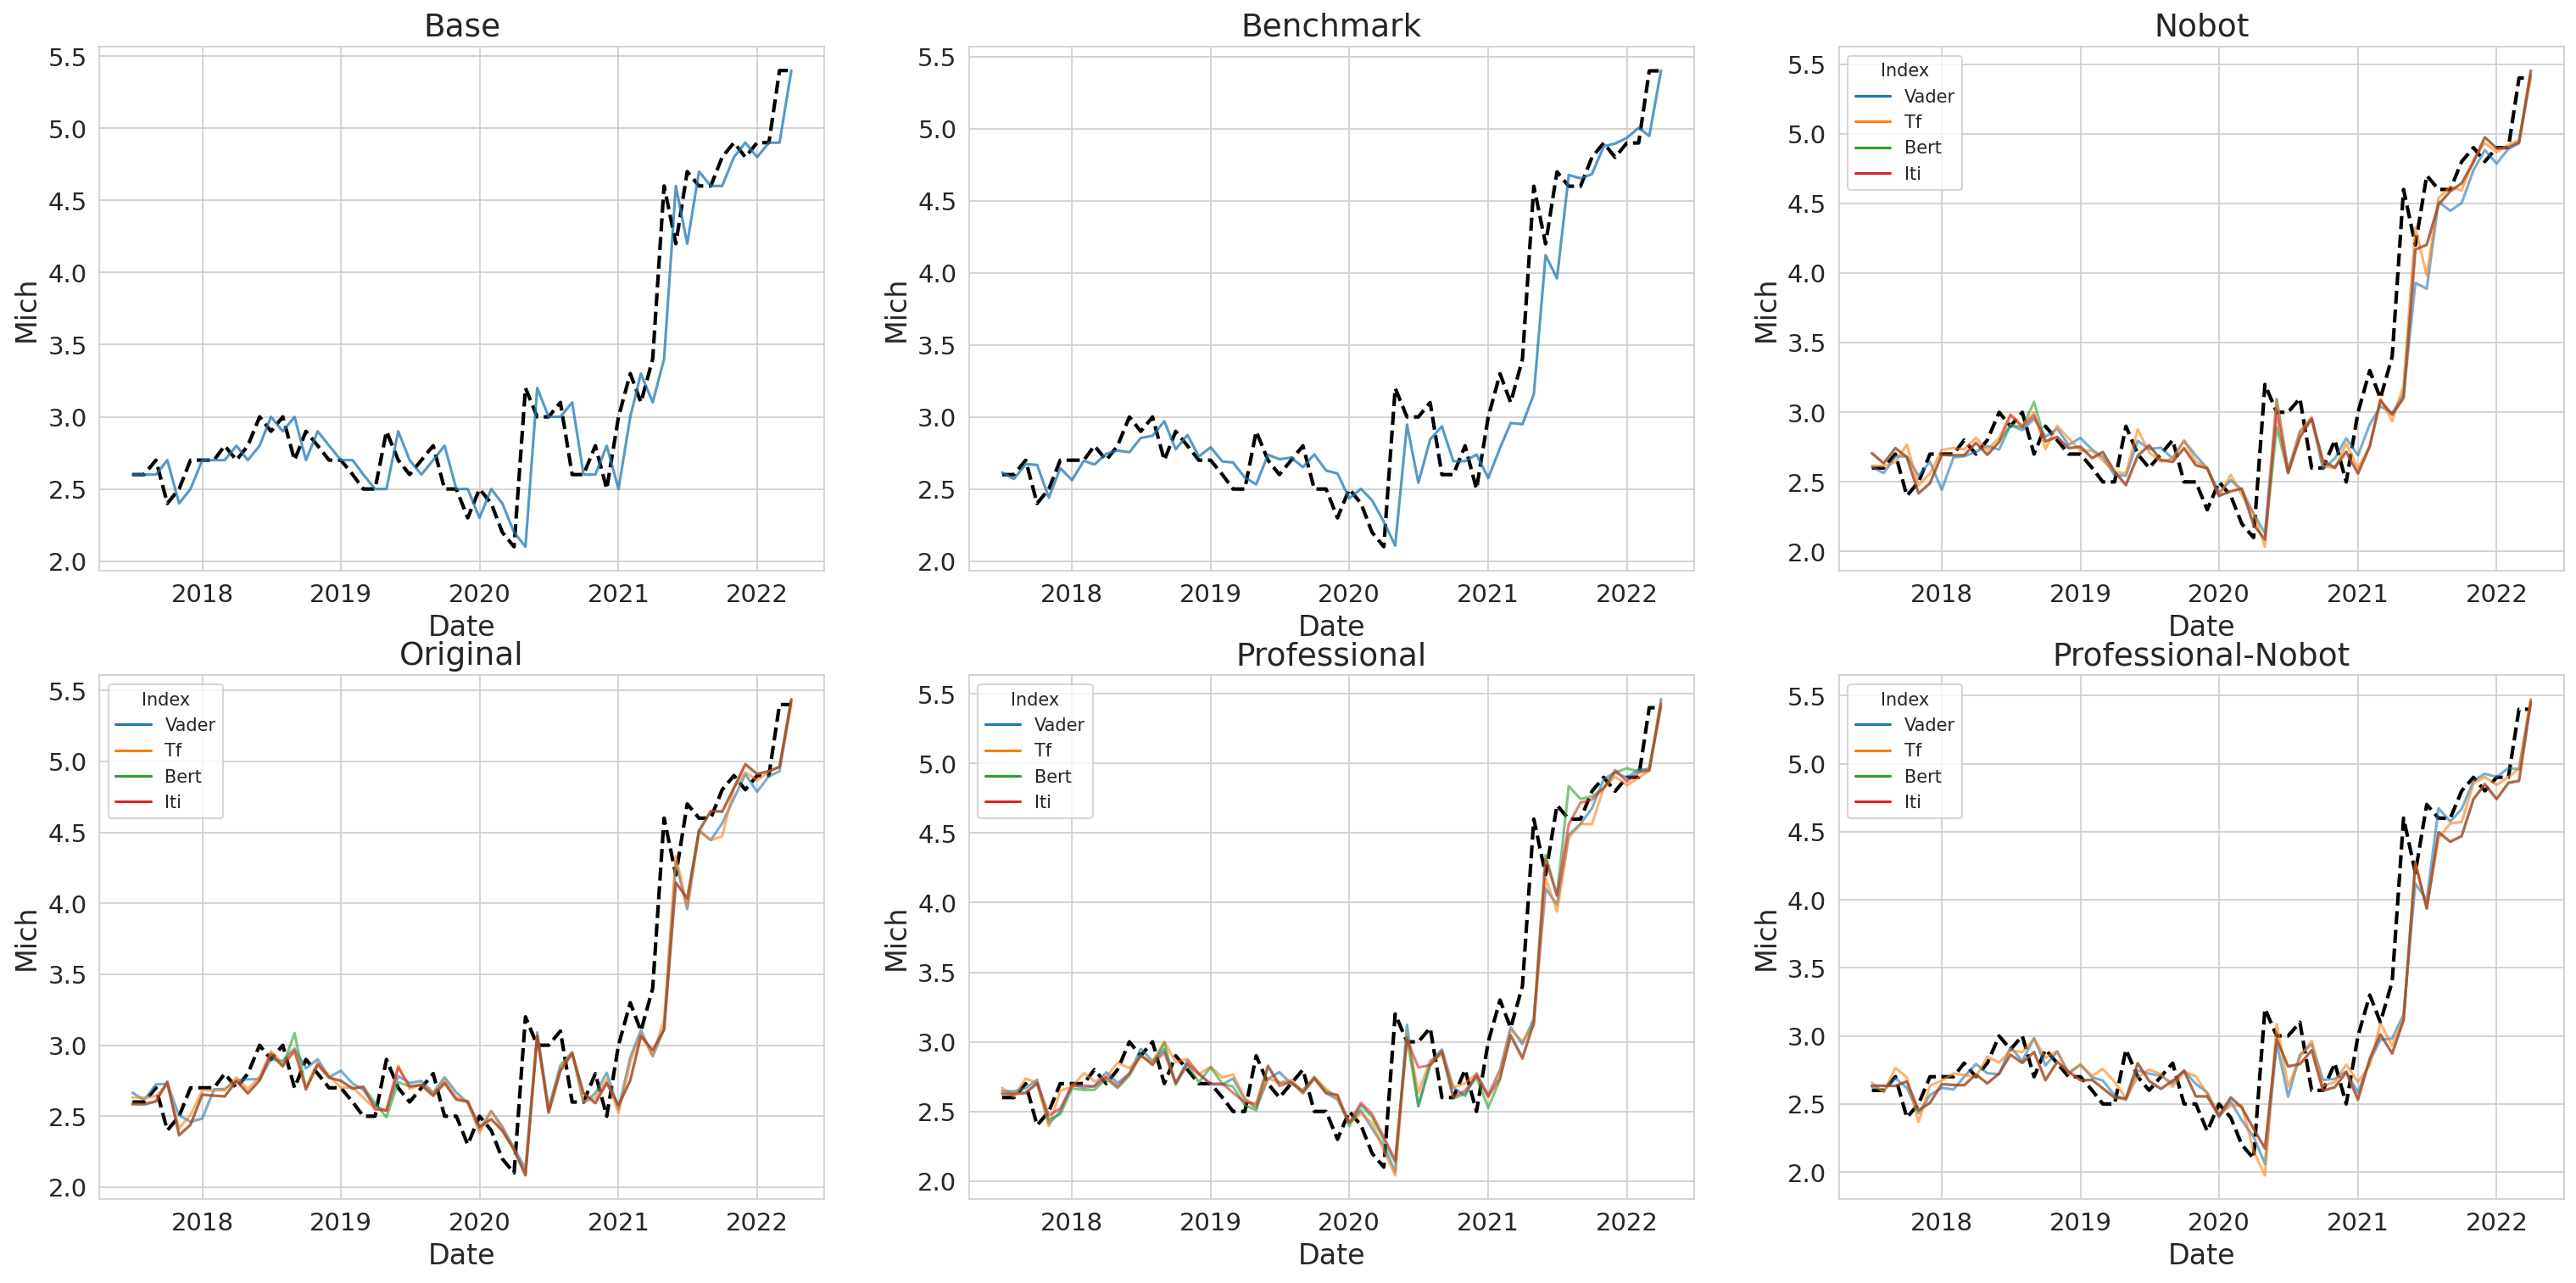

In [ ]:
inflation_measure = 'Mich'
df_test_inflation = df_inflation.loc[df_forecast.index]
fig, axs = plt.subplots(2, df_forecasts_melted['Dataset'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
for i, dataset in enumerate(df_forecasts_melted.sort_values('Dataset')['Dataset'].unique()):
  axs[i].plot(pd.to_datetime(df_test_inflation.index), df_test_inflation[inflation_measure.upper()], '--', lw=2, c='black')
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(dataset, fontsize=18)
  if dataset == 'Base' or dataset == 'Benchmark':
    sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                          (df_forecasts_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_forecasts_melted[(df_forecasts_melted['InflationMeasure'] == inflation_measure) &
                                          (df_forecasts_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', hue='Index', ax=axs[i], alpha=.6)

## Mean Squared Forecast Error (MSFE) Tables

In [ ]:
df_msfe = df_forecasts_errors.mean().sort_values().reset_index()
df_msfe.columns = ['Id', 'MSFE']
df_msfe['InflationMeasure'] = df_msfe['Id'].apply(lambda x: x.split('-')[-1])
df_msfe['Index'] = df_msfe['Id'].apply(lambda x: '-'.join(x.split('-')[:-1]).split('_')[-1])
df_msfe['Dataset'] = df_msfe['Id'].apply(lambda x: '-'.join(x.split('-')[:-1]).split('_')[0])
df_msfe.pivot(['Index', 'Dataset'], 'InflationMeasure', 'MSFE').to_csv('MSFE.csv')
df_msfe.pivot(['Index', 'Dataset'], 'InflationMeasure', 'MSFE')

InflationMeasure              INFLATION      MICH
Index     Dataset                                
Base      Base                 0.067860  0.088966
Benchmark Benchmark            0.063976  0.103291
Bert      NoBot                0.062392  0.105231
          Original             0.063207  0.111030
          Professional         0.061735  0.107973
          Professional-NoBot   0.061538  0.107200
ITI       NoBot                0.063979  0.103791
          Original             0.063524  0.109038
          Professional         0.063074  0.100928
          Professional-NoBot   0.061487  0.107200
TF        NoBot                0.063680  0.107488
          Original             0.063992  0.105736
          Professional         0.065353  0.106959
          Professional-NoBot   0.067136  0.111159
Vader     NoBot                0.071143  0.107168
          Original             0.067670  0.108473
          Professional         0.067412  0.104925
          Professional-NoBot   0.065477  0.102983

In [ ]:
df_msfe[df_msfe['InflationMeasure'] == 'INFLATION'].pivot('Index', 'Dataset', 'MSFE').fillna(method='ffill', axis=1).dropna(axis=1).style.highlight_between(left=0.06, right=0.0632, color='#d1ecfc').highlight_min(color='#77c6f7', axis=None)

In [ ]:
df_msfe[df_msfe['InflationMeasure'] == 'MICH'].pivot('Index', 'Dataset', 'MSFE').fillna(method='ffill', axis=1).dropna(axis=1).style.highlight_between(left=0., right=0.104, color='#d1ecfc').highlight_min(color='#77c6f7', axis=None)

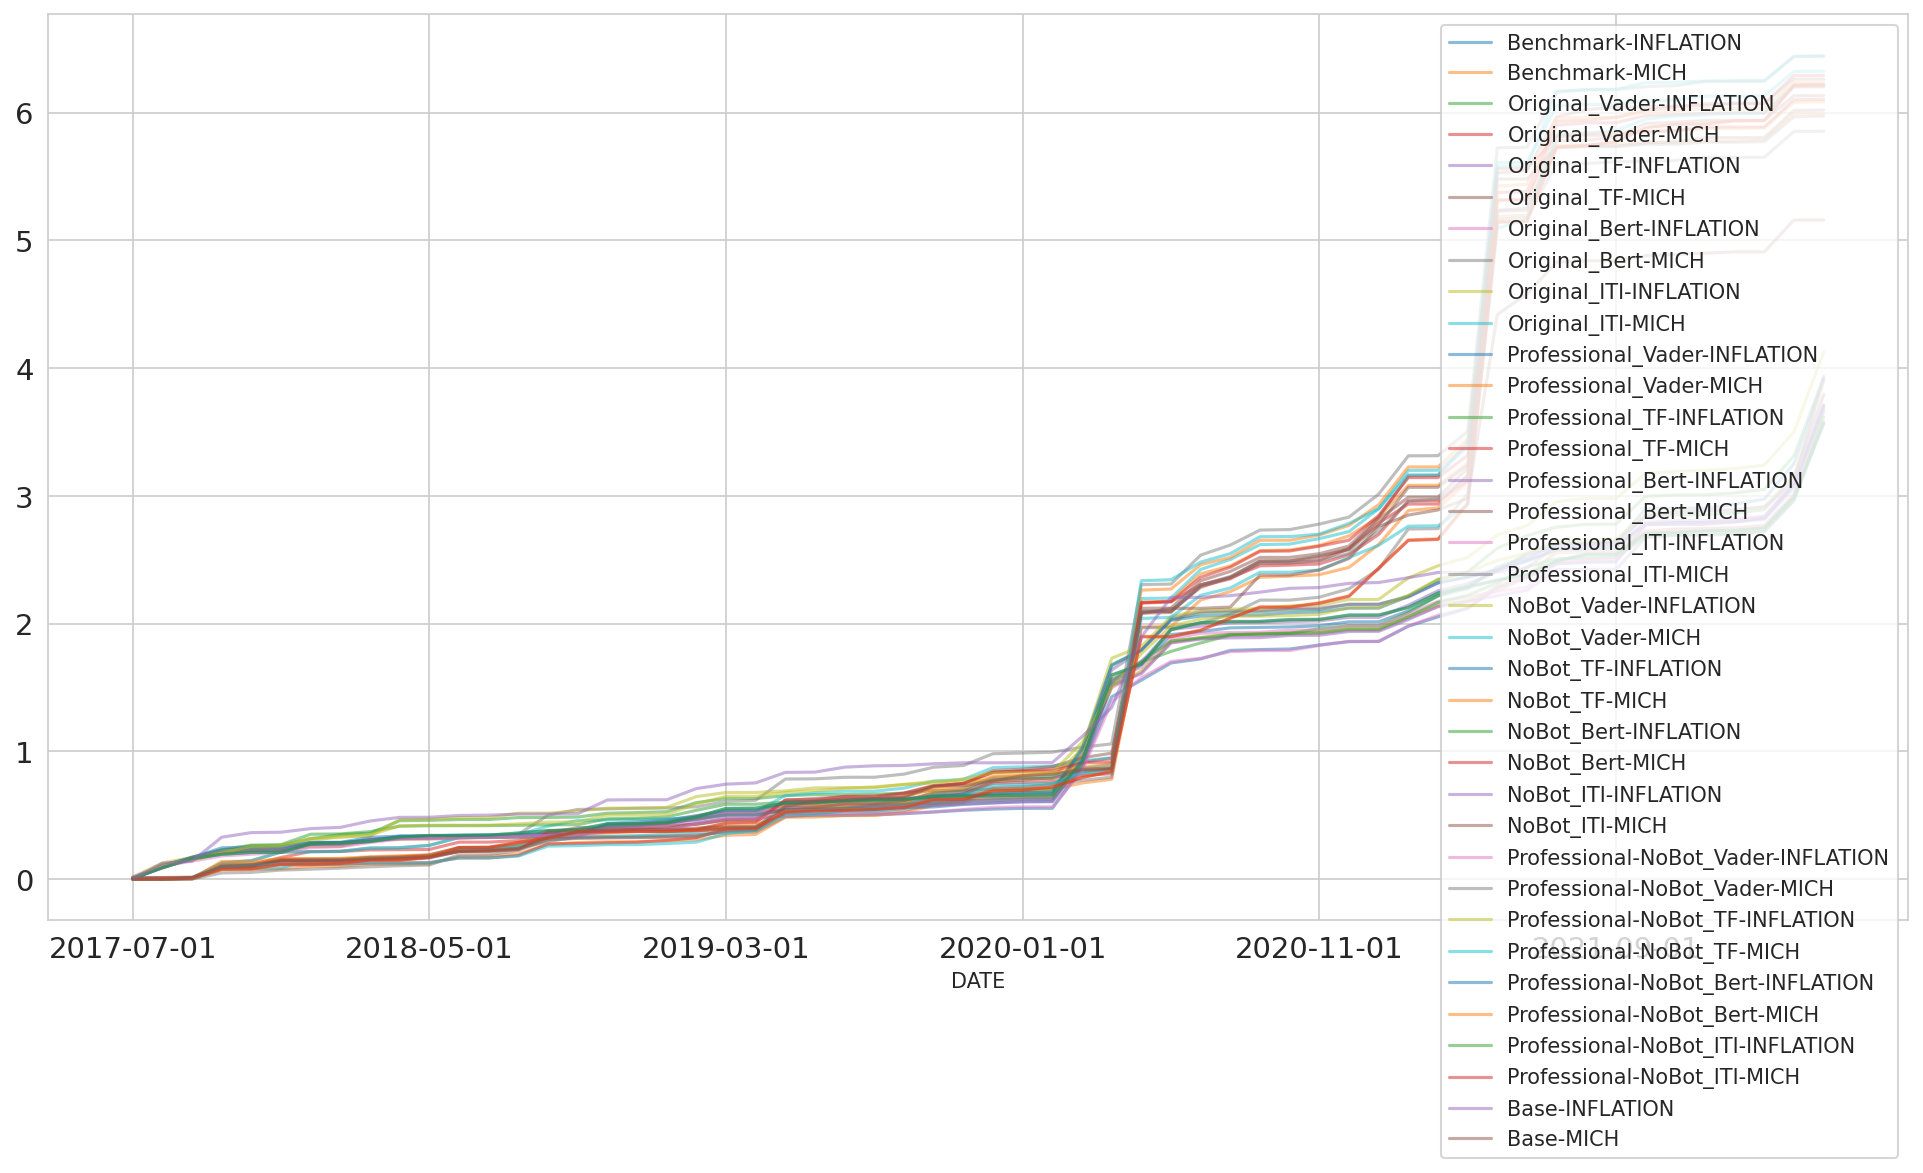

In [ ]:
df_forecasts_errors.cumsum().plot(alpha=.5)

In [ ]:
# df_signals_aux = df_signals.copy()
# df_signals_aux['Date'] = pd.to_datetime(df_signals_aux['DATE'])
# sns.lineplot(data=df_signals_aux[['Date'] + list(map(lambda x: '-'.join(x.split('-')[:-1]), top_columns_infls))].melt('Date'),
#              x='Date', y='value', hue='variable', style='variable')

## Top 4 Signals


### Inflation

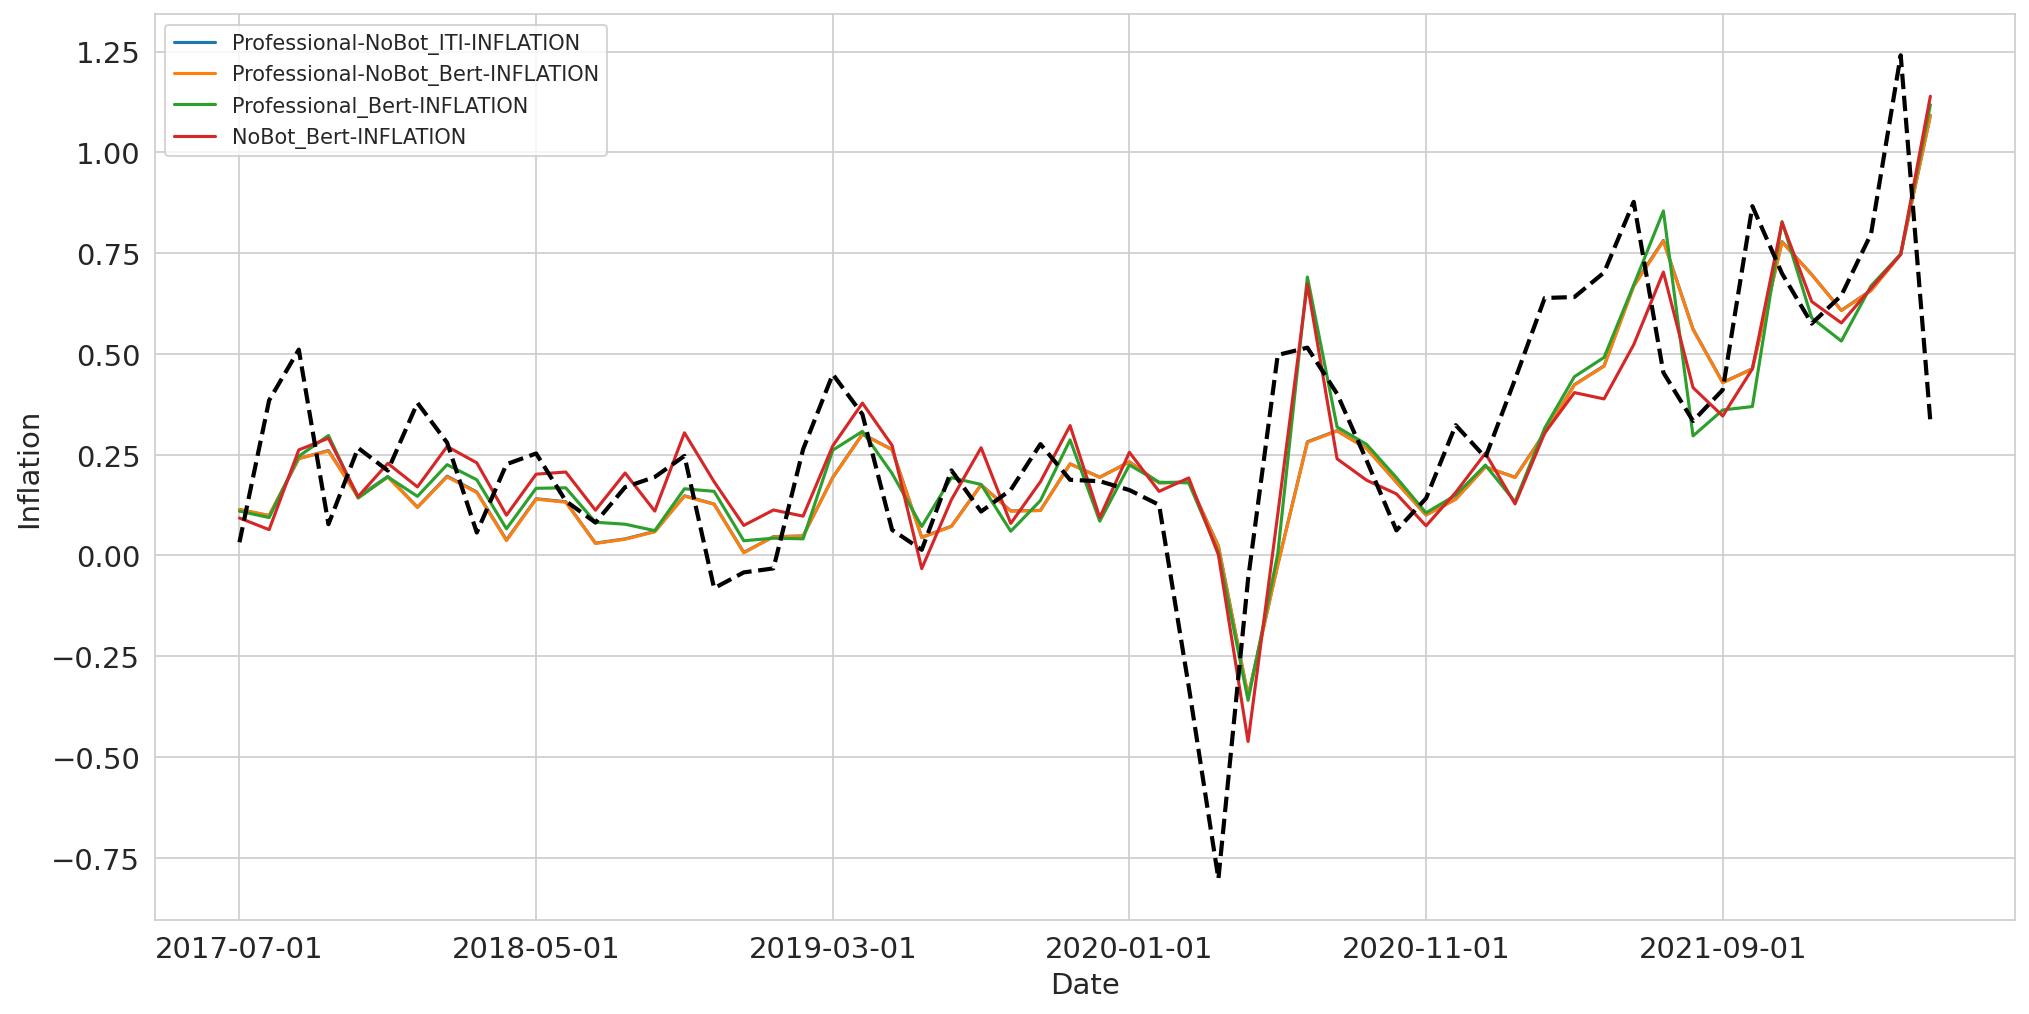

In [ ]:
infl_columns = df_forecasts_errors.columns[(pd.Series(df_forecasts_errors.columns).apply(lambda x: x.split('-')[-1].title()) == 'Inflation').values].values
top_columns_infls = df_forecasts_errors[infl_columns].mean().sort_values().iloc[:4].index.values
df_forecasts[top_columns_infls].plot()
plt.plot(df_forecasts.index, df_test_inflation['INFLATION'], '--', lw=2, c='black')
plt.ylabel('Inflation', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

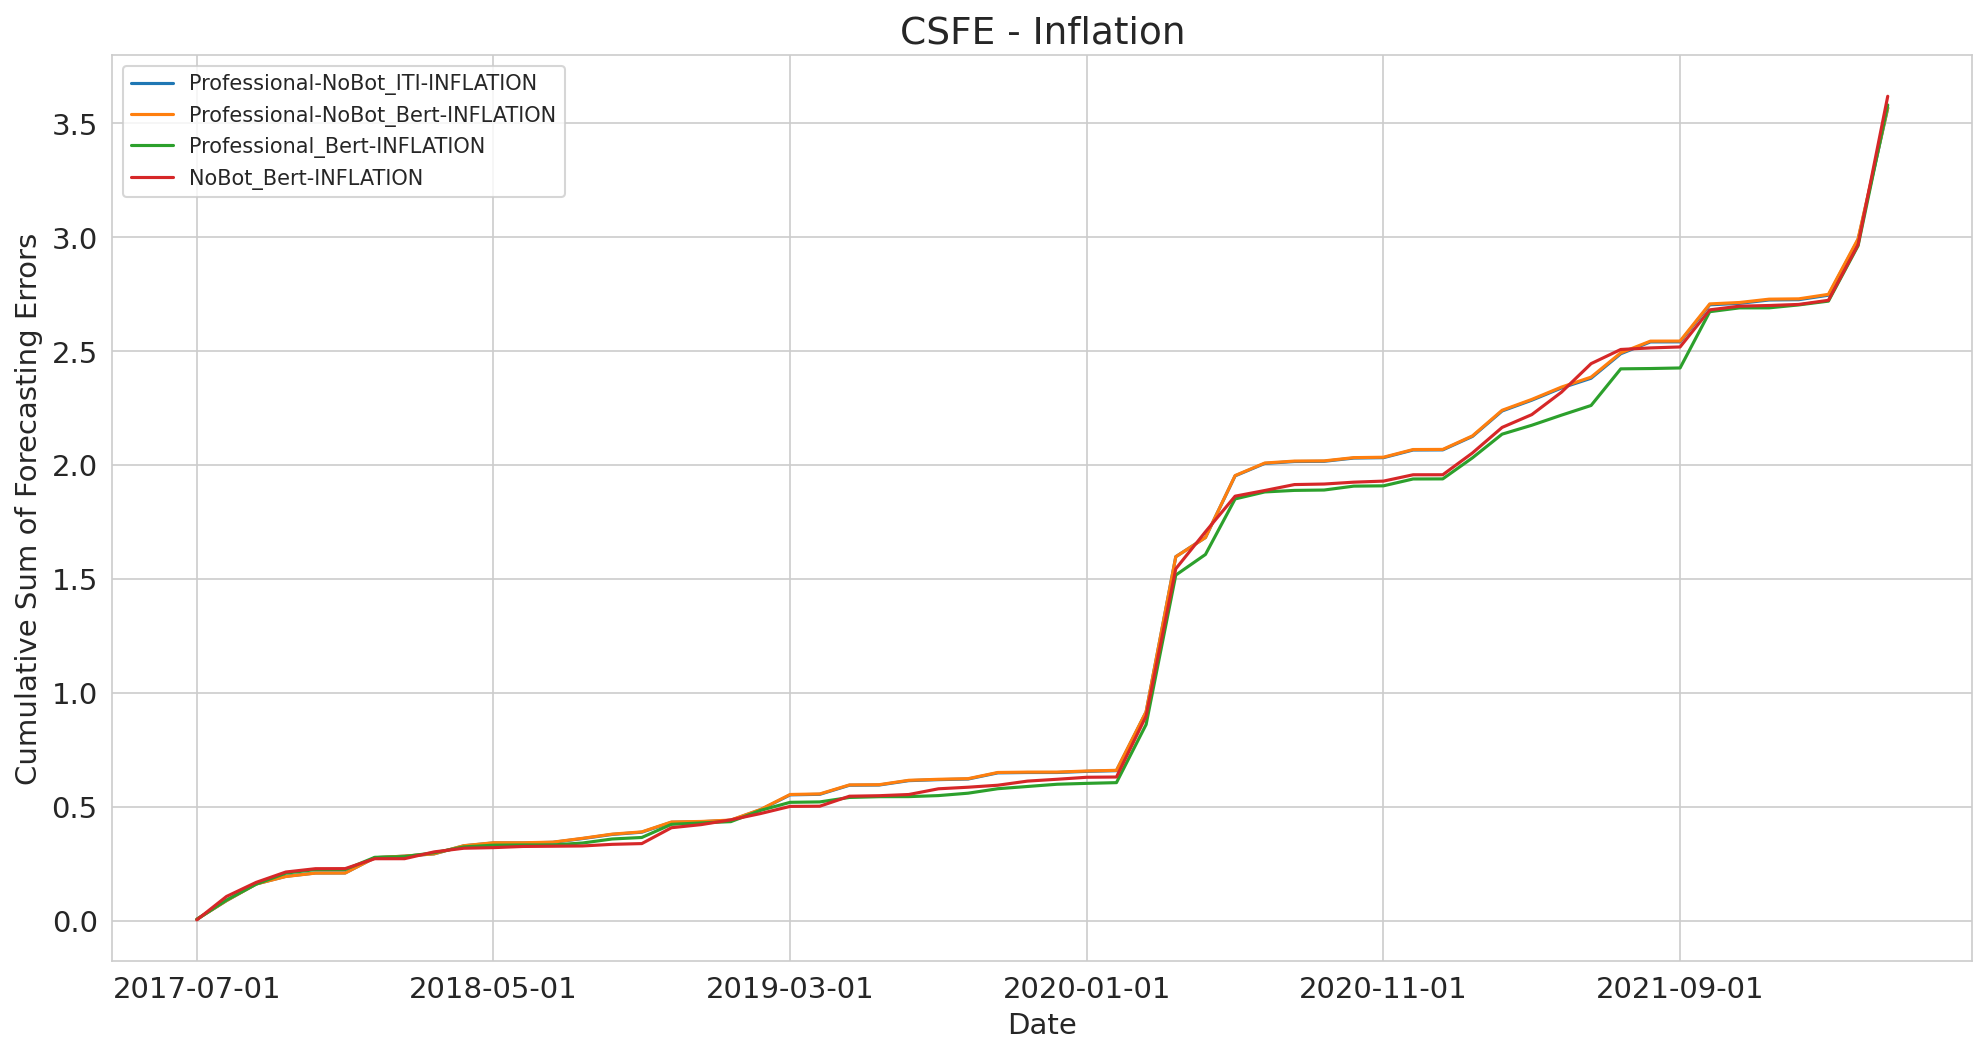

In [ ]:
df_forecasts_errors[df_forecasts_errors[infl_columns].mean().sort_values().iloc[:4].index.values].cumsum().plot()
plt.ylabel('Cumulative Sum of Forecasting Errors', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.title('CSFE - Inflation', fontsize=18)
plt.show()

### Mich

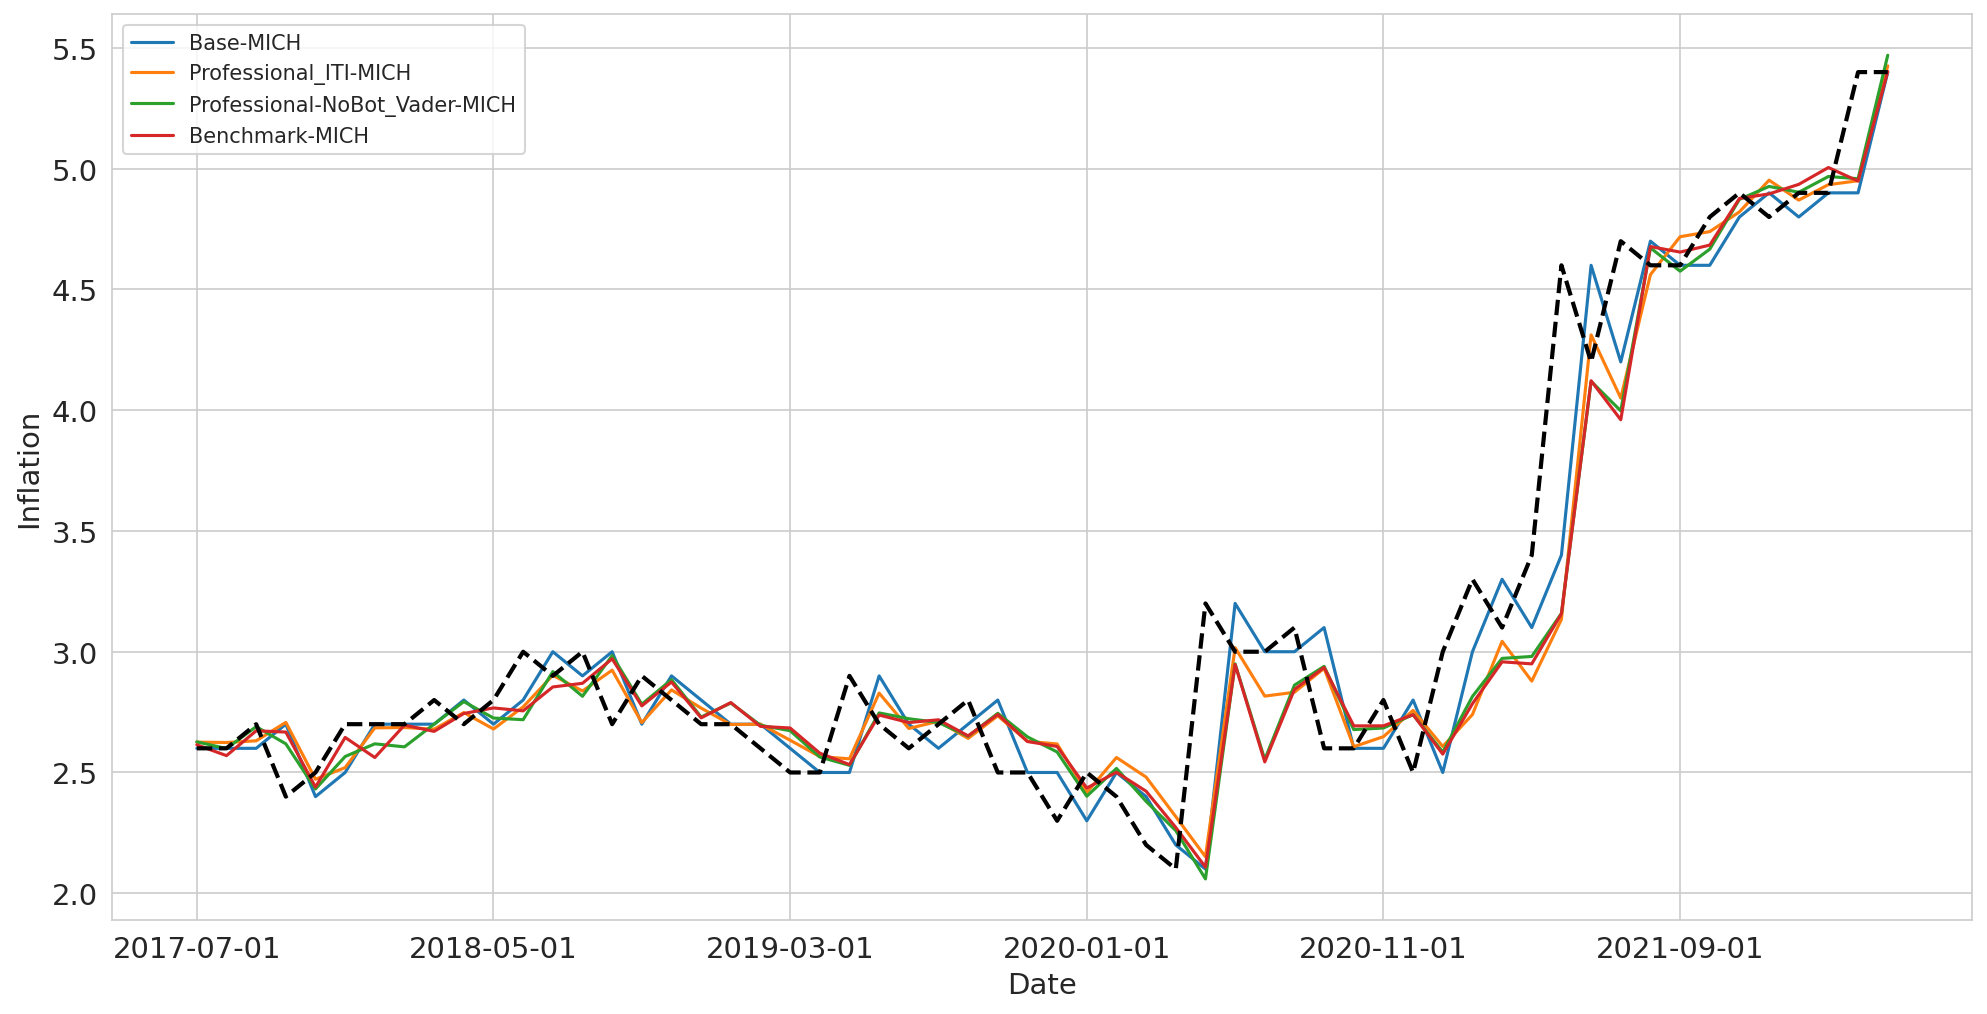

In [ ]:
mich_columns = df_forecasts_errors.columns[(pd.Series(df_forecasts_errors.columns).apply(lambda x: x.split('-')[-1].title()) == 'Mich').values].values
df_forecasts[df_forecasts_errors[mich_columns].mean().sort_values().iloc[:4].index.values].plot()
plt.plot(df_forecasts.index, df_test_inflation['MICH'], '--', lw=2, c='black')
plt.ylabel('Inflation', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

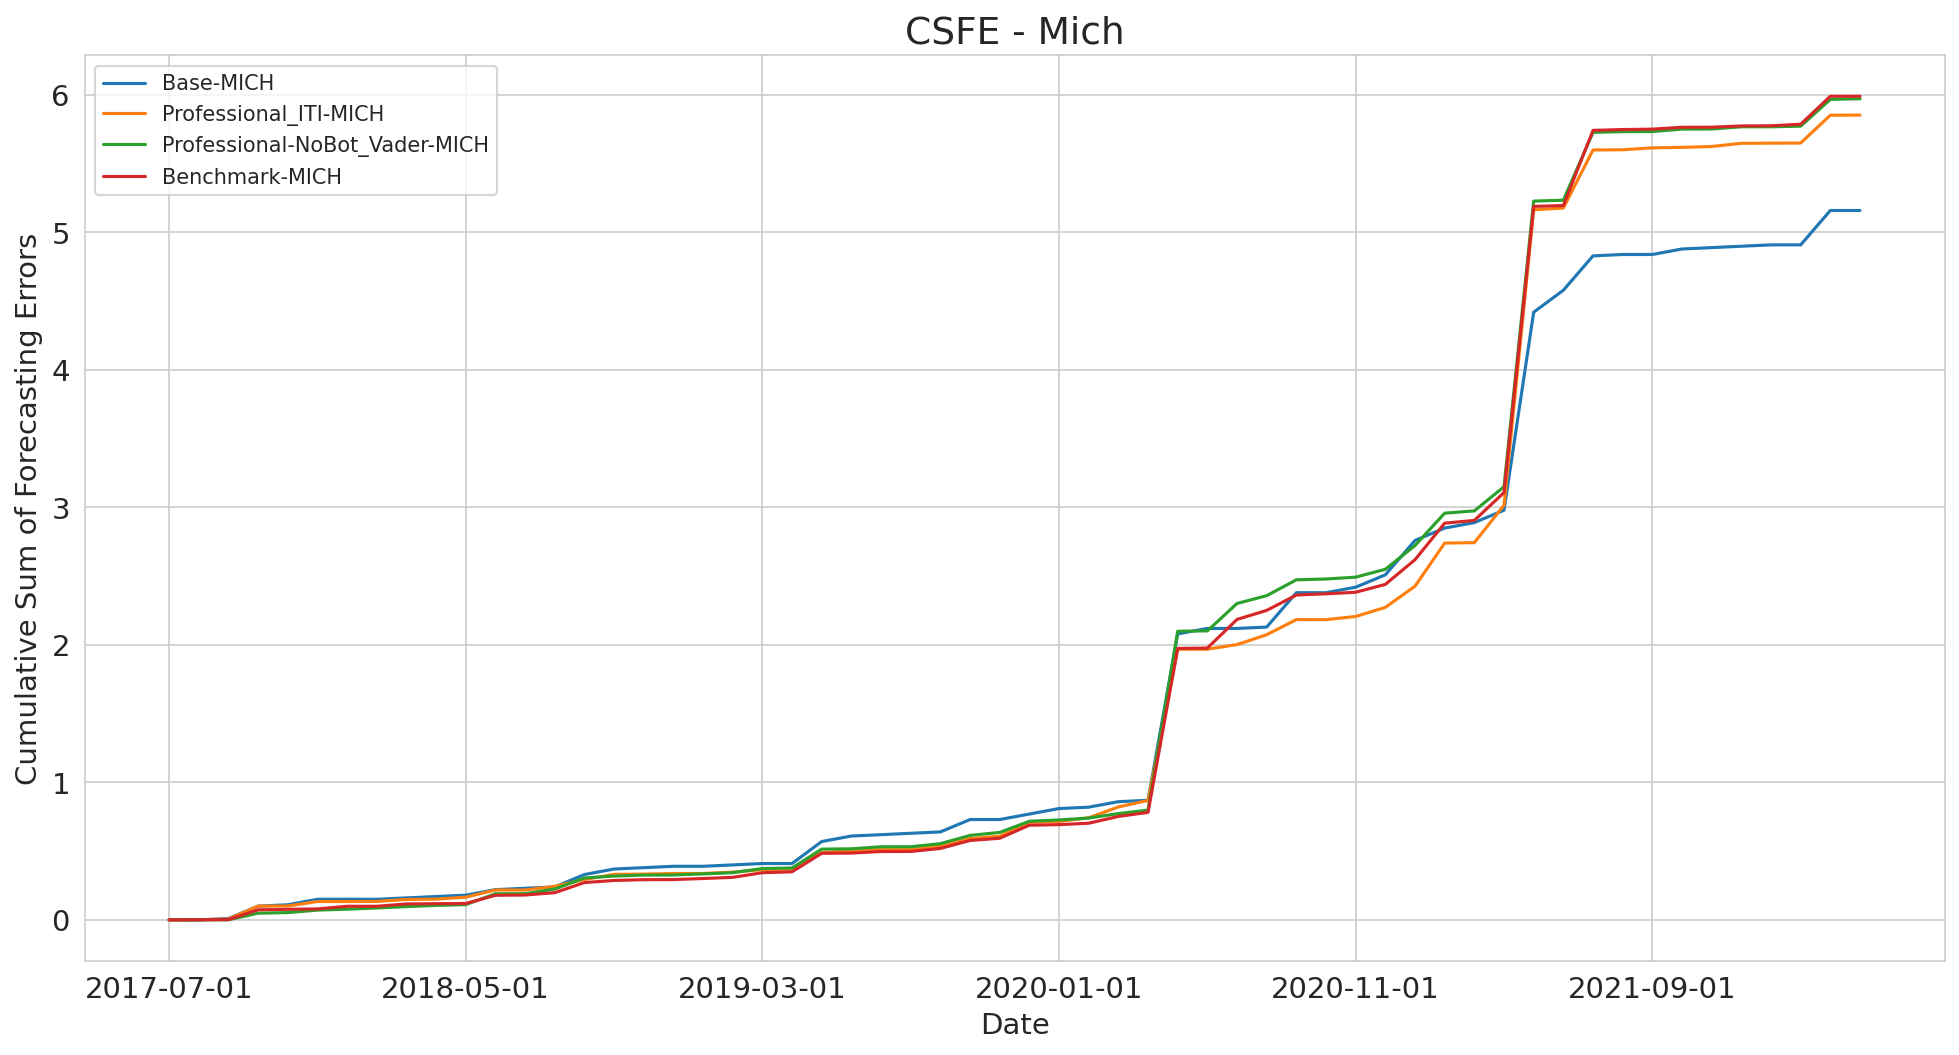

In [ ]:
df_forecasts_errors[df_forecasts_errors[mich_columns].mean().sort_values().iloc[:4].index.values].cumsum().plot()
plt.ylabel('Cumulative Sum of Forecasting Errors', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.title('CSFE - Mich', fontsize=18)
plt.show()

## Cumulative Sum of Forecasting Errors (CSFE) Plots

In [ ]:
df_csfe_melted = df_forecasts_errors.cumsum().reset_index().melt('DATE')
df_csfe_melted.columns = ['DATE', 'Id', 'Value']
df_csfe_melted['DATE'] = pd.to_datetime(df_forecasts_melted['DATE'])
df_csfe_melted['InflationMeasure'] = df_forecasts_melted['Id'].apply(lambda x: x.split('-')[-1].title())
df_csfe_melted['Index'] = df_forecasts_melted['Id'].apply(lambda x: '-'.join(x.split('-')[:-1]).split('_')[-1].title())
df_csfe_melted['Dataset'] = df_forecasts_melted['Id'].apply(lambda x: '-'.join(x.split('-')[:-1]).split('_')[0].title())
df_csfe_melted.head()

DATE                   Id     Value InflationMeasure      Index  \
0 2017-07-01  Benchmark-INFLATION  0.015246        Inflation  Benchmark   
1 2017-08-01  Benchmark-INFLATION  0.105289        Inflation  Benchmark   
2 2017-09-01  Benchmark-INFLATION  0.151665        Inflation  Benchmark   
3 2017-10-01  Benchmark-INFLATION  0.201548        Inflation  Benchmark   
4 2017-11-01  Benchmark-INFLATION  0.221862        Inflation  Benchmark   

     Dataset  
0  Benchmark  
1  Benchmark  
2  Benchmark  
3  Benchmark  
4  Benchmark

### Inflation

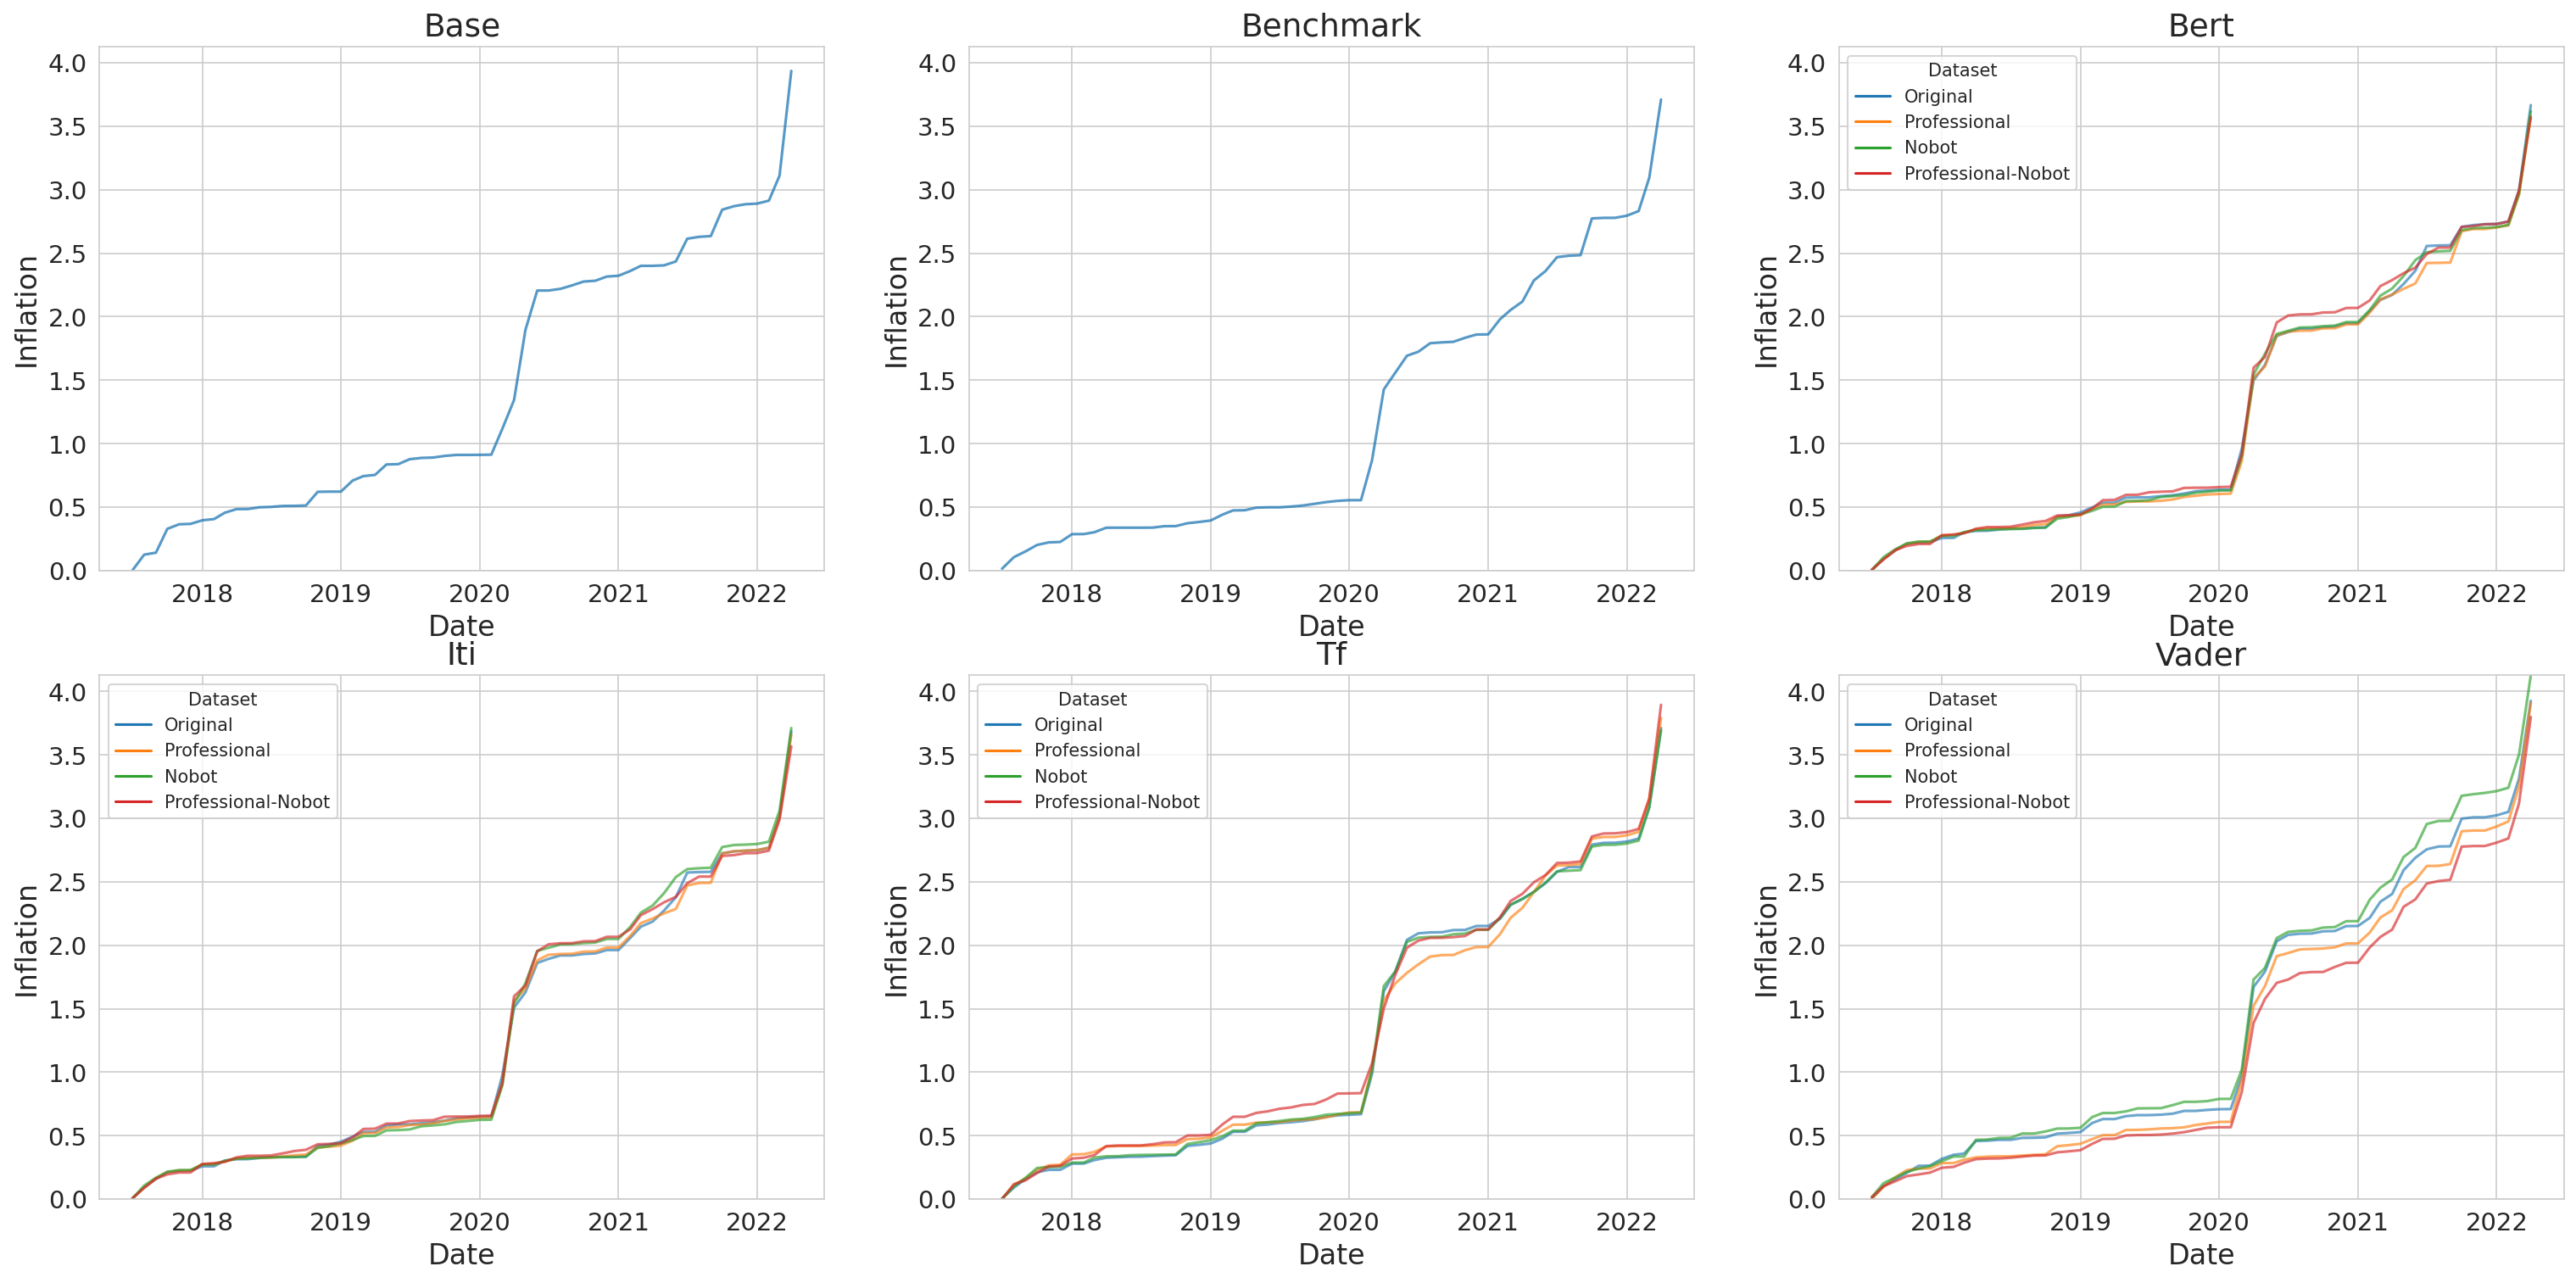

In [ ]:
inflation_measure = 'Inflation'
fig, axs = plt.subplots(2, df_csfe_melted['Index'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
max_cumulative_error = df_csfe_melted[df_csfe_melted['InflationMeasure'] == inflation_measure]['Value'].max()
for i, index in enumerate(df_csfe_melted.sort_values('Index')['Index'].unique()):
  axs[i].set_ylim(0, max_cumulative_error)
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(index, fontsize=18)
  if index == 'Base' or index == 'Benchmark':
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                   (df_csfe_melted['Index'] == index)], 
                 x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                   (df_csfe_melted['Index'] == index)], 
                 x='DATE', y='Value', hue='Dataset', ax=axs[i], alpha=.65)

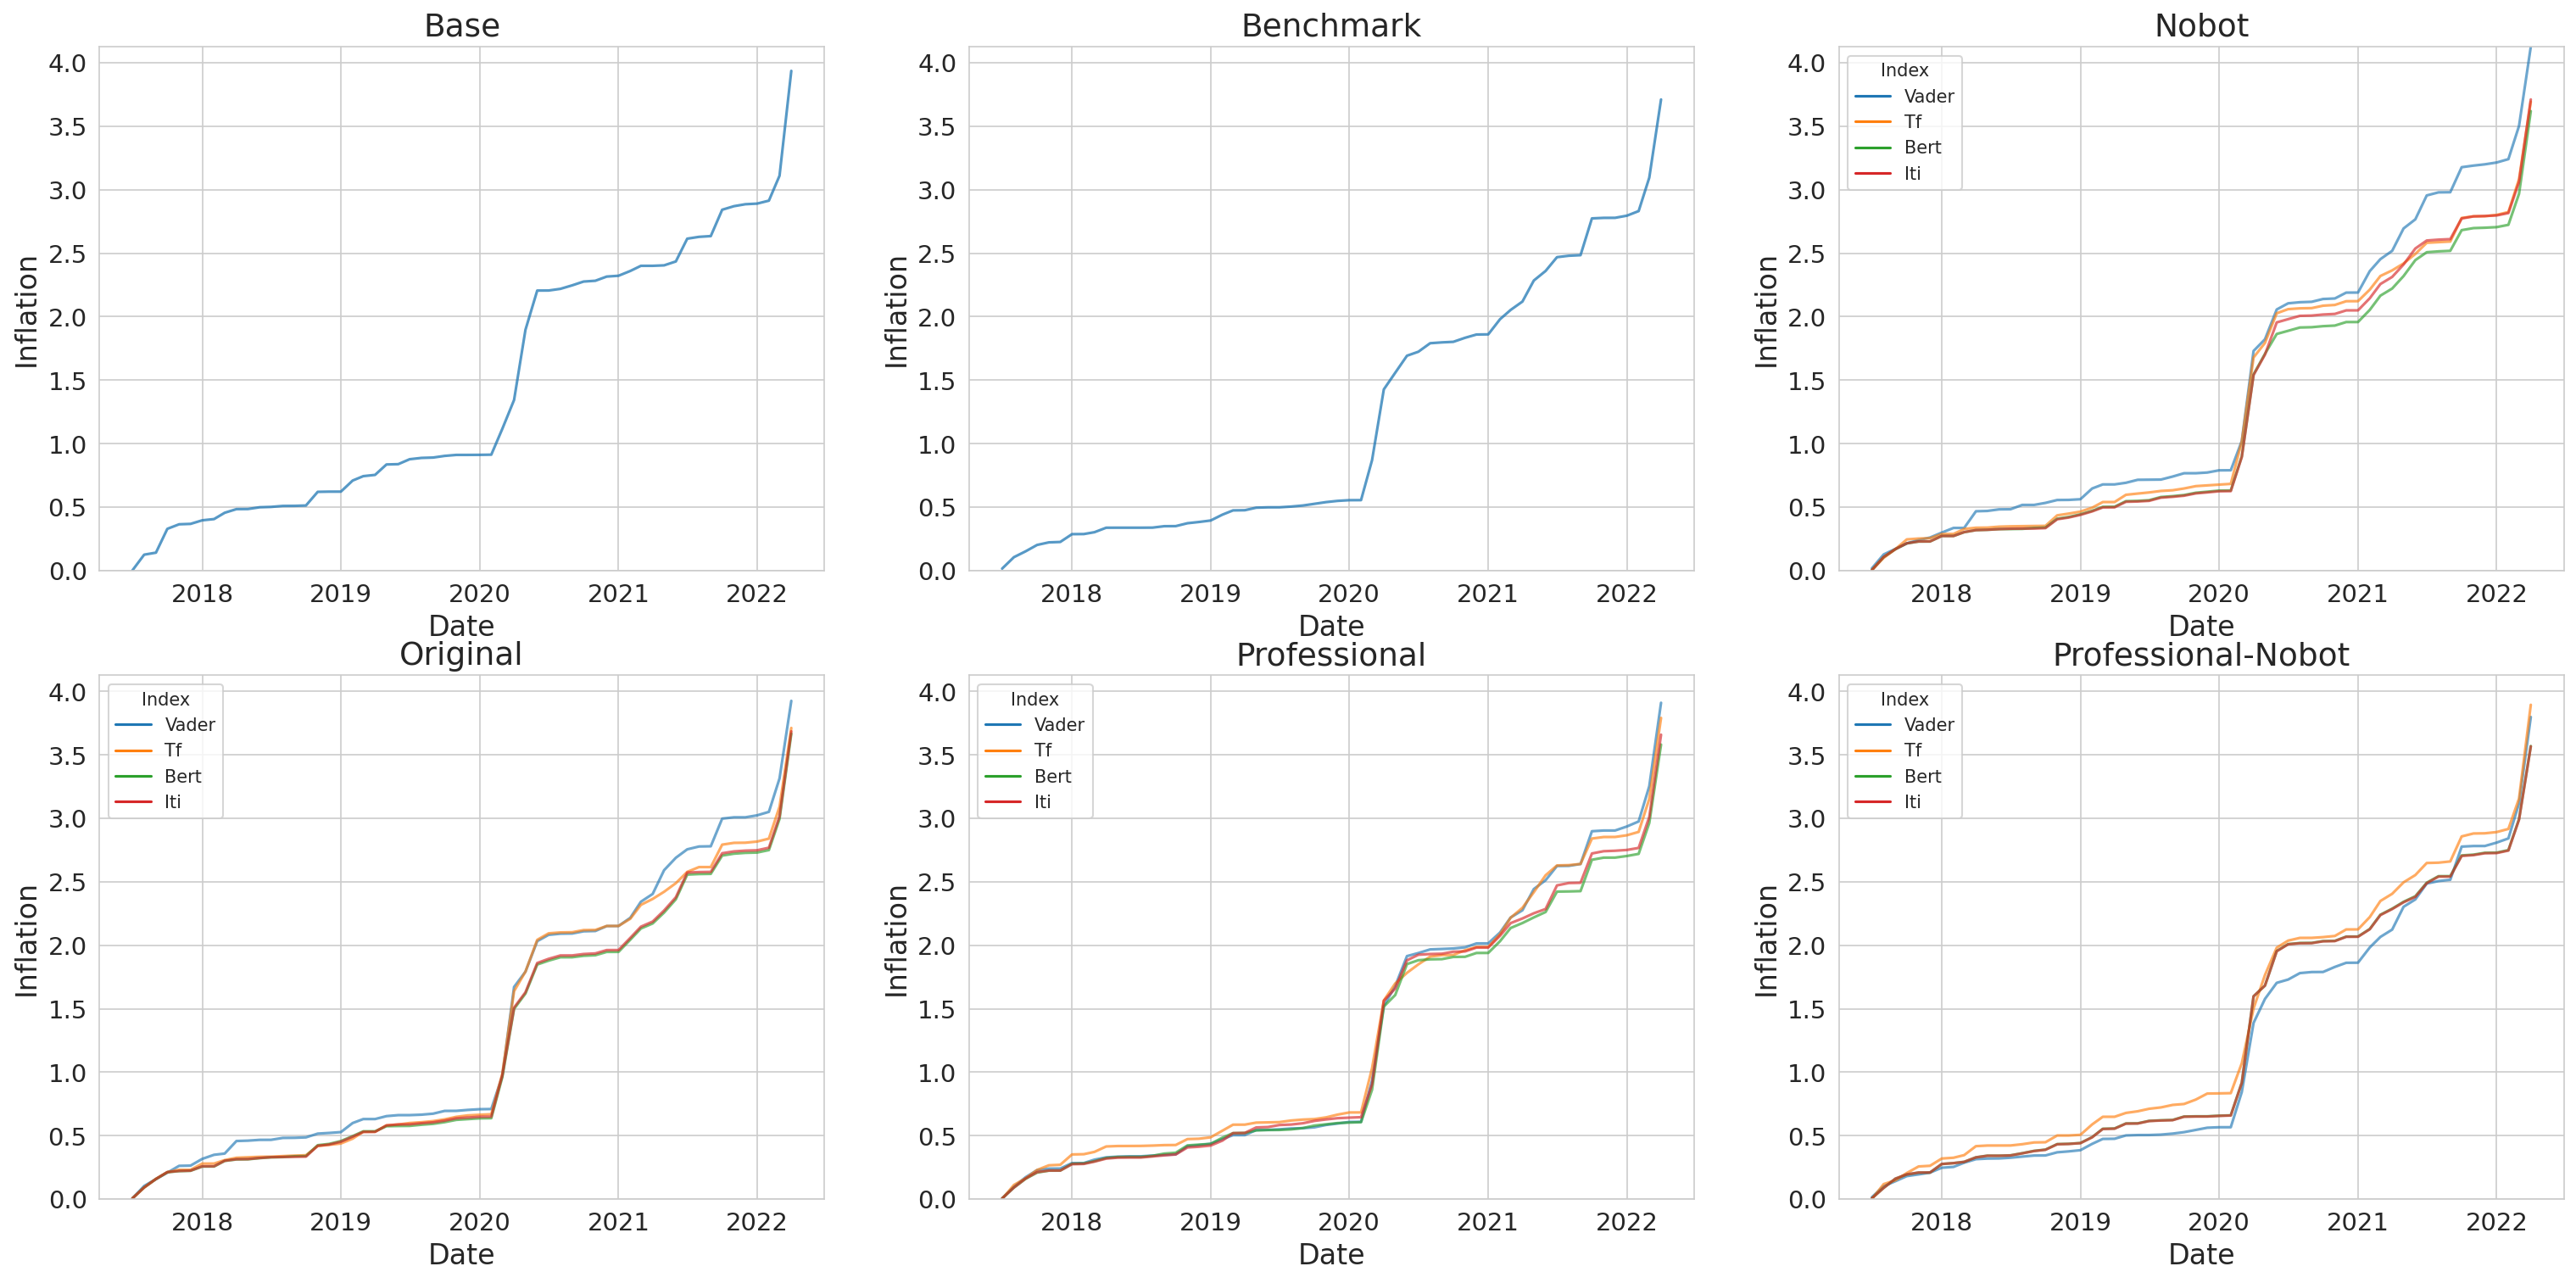

In [ ]:
inflation_measure = 'Inflation'
fig, axs = plt.subplots(2, df_csfe_melted['Dataset'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
max_cumulative_error = df_csfe_melted[df_csfe_melted['InflationMeasure'] == inflation_measure]['Value'].max()
for i, dataset in enumerate(df_csfe_melted.sort_values('Dataset')['Dataset'].unique()):
  axs[i].set_ylim(0, max_cumulative_error)
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(dataset, fontsize=18)
  if dataset == 'Base' or dataset == 'Benchmark':
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                   (df_csfe_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                    (df_csfe_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', hue='Index', ax=axs[i], alpha=.65)

### Mich

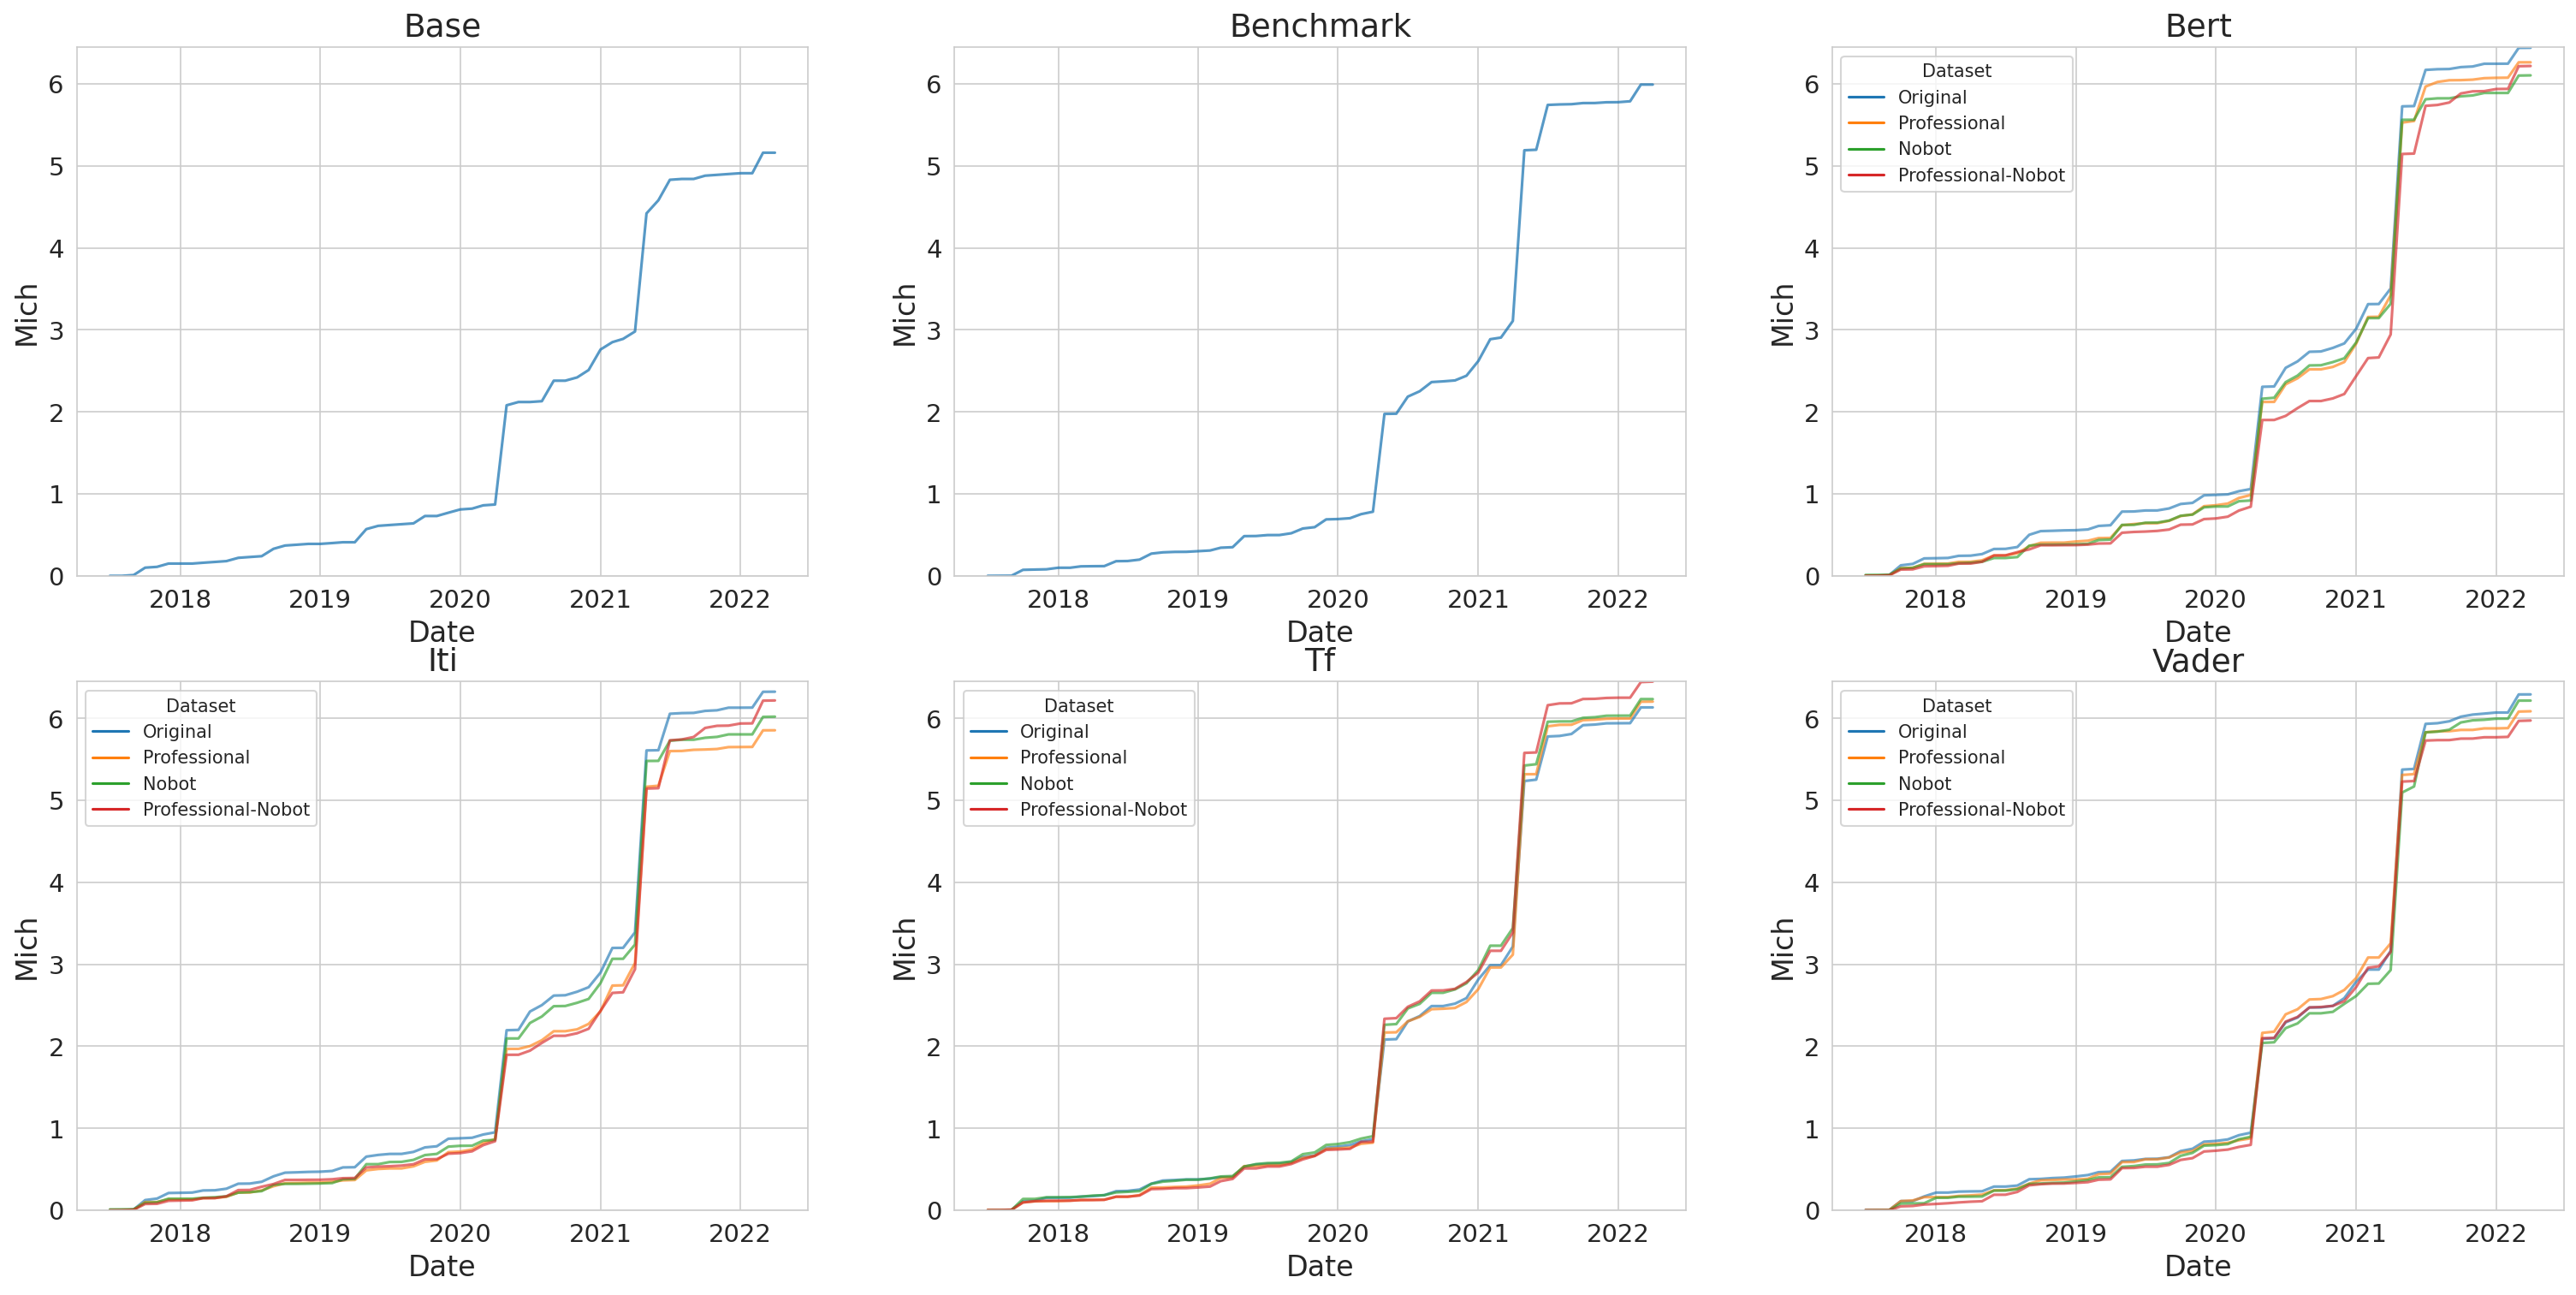

In [ ]:
inflation_measure = 'Mich'
fig, axs = plt.subplots(2, df_csfe_melted['Index'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
max_cumulative_error = df_csfe_melted[df_csfe_melted['InflationMeasure'] == inflation_measure]['Value'].max()
for i, index in enumerate(df_csfe_melted.sort_values('Index')['Index'].unique()):
  axs[i].set_ylim(0, max_cumulative_error)
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(index, fontsize=18)
  if index == 'Base' or index == 'Benchmark':
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                   (df_csfe_melted['Index'] == index)], 
                 x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                   (df_csfe_melted['Index'] == index)], 
                 x='DATE', y='Value', hue='Dataset', ax=axs[i], alpha=.65)

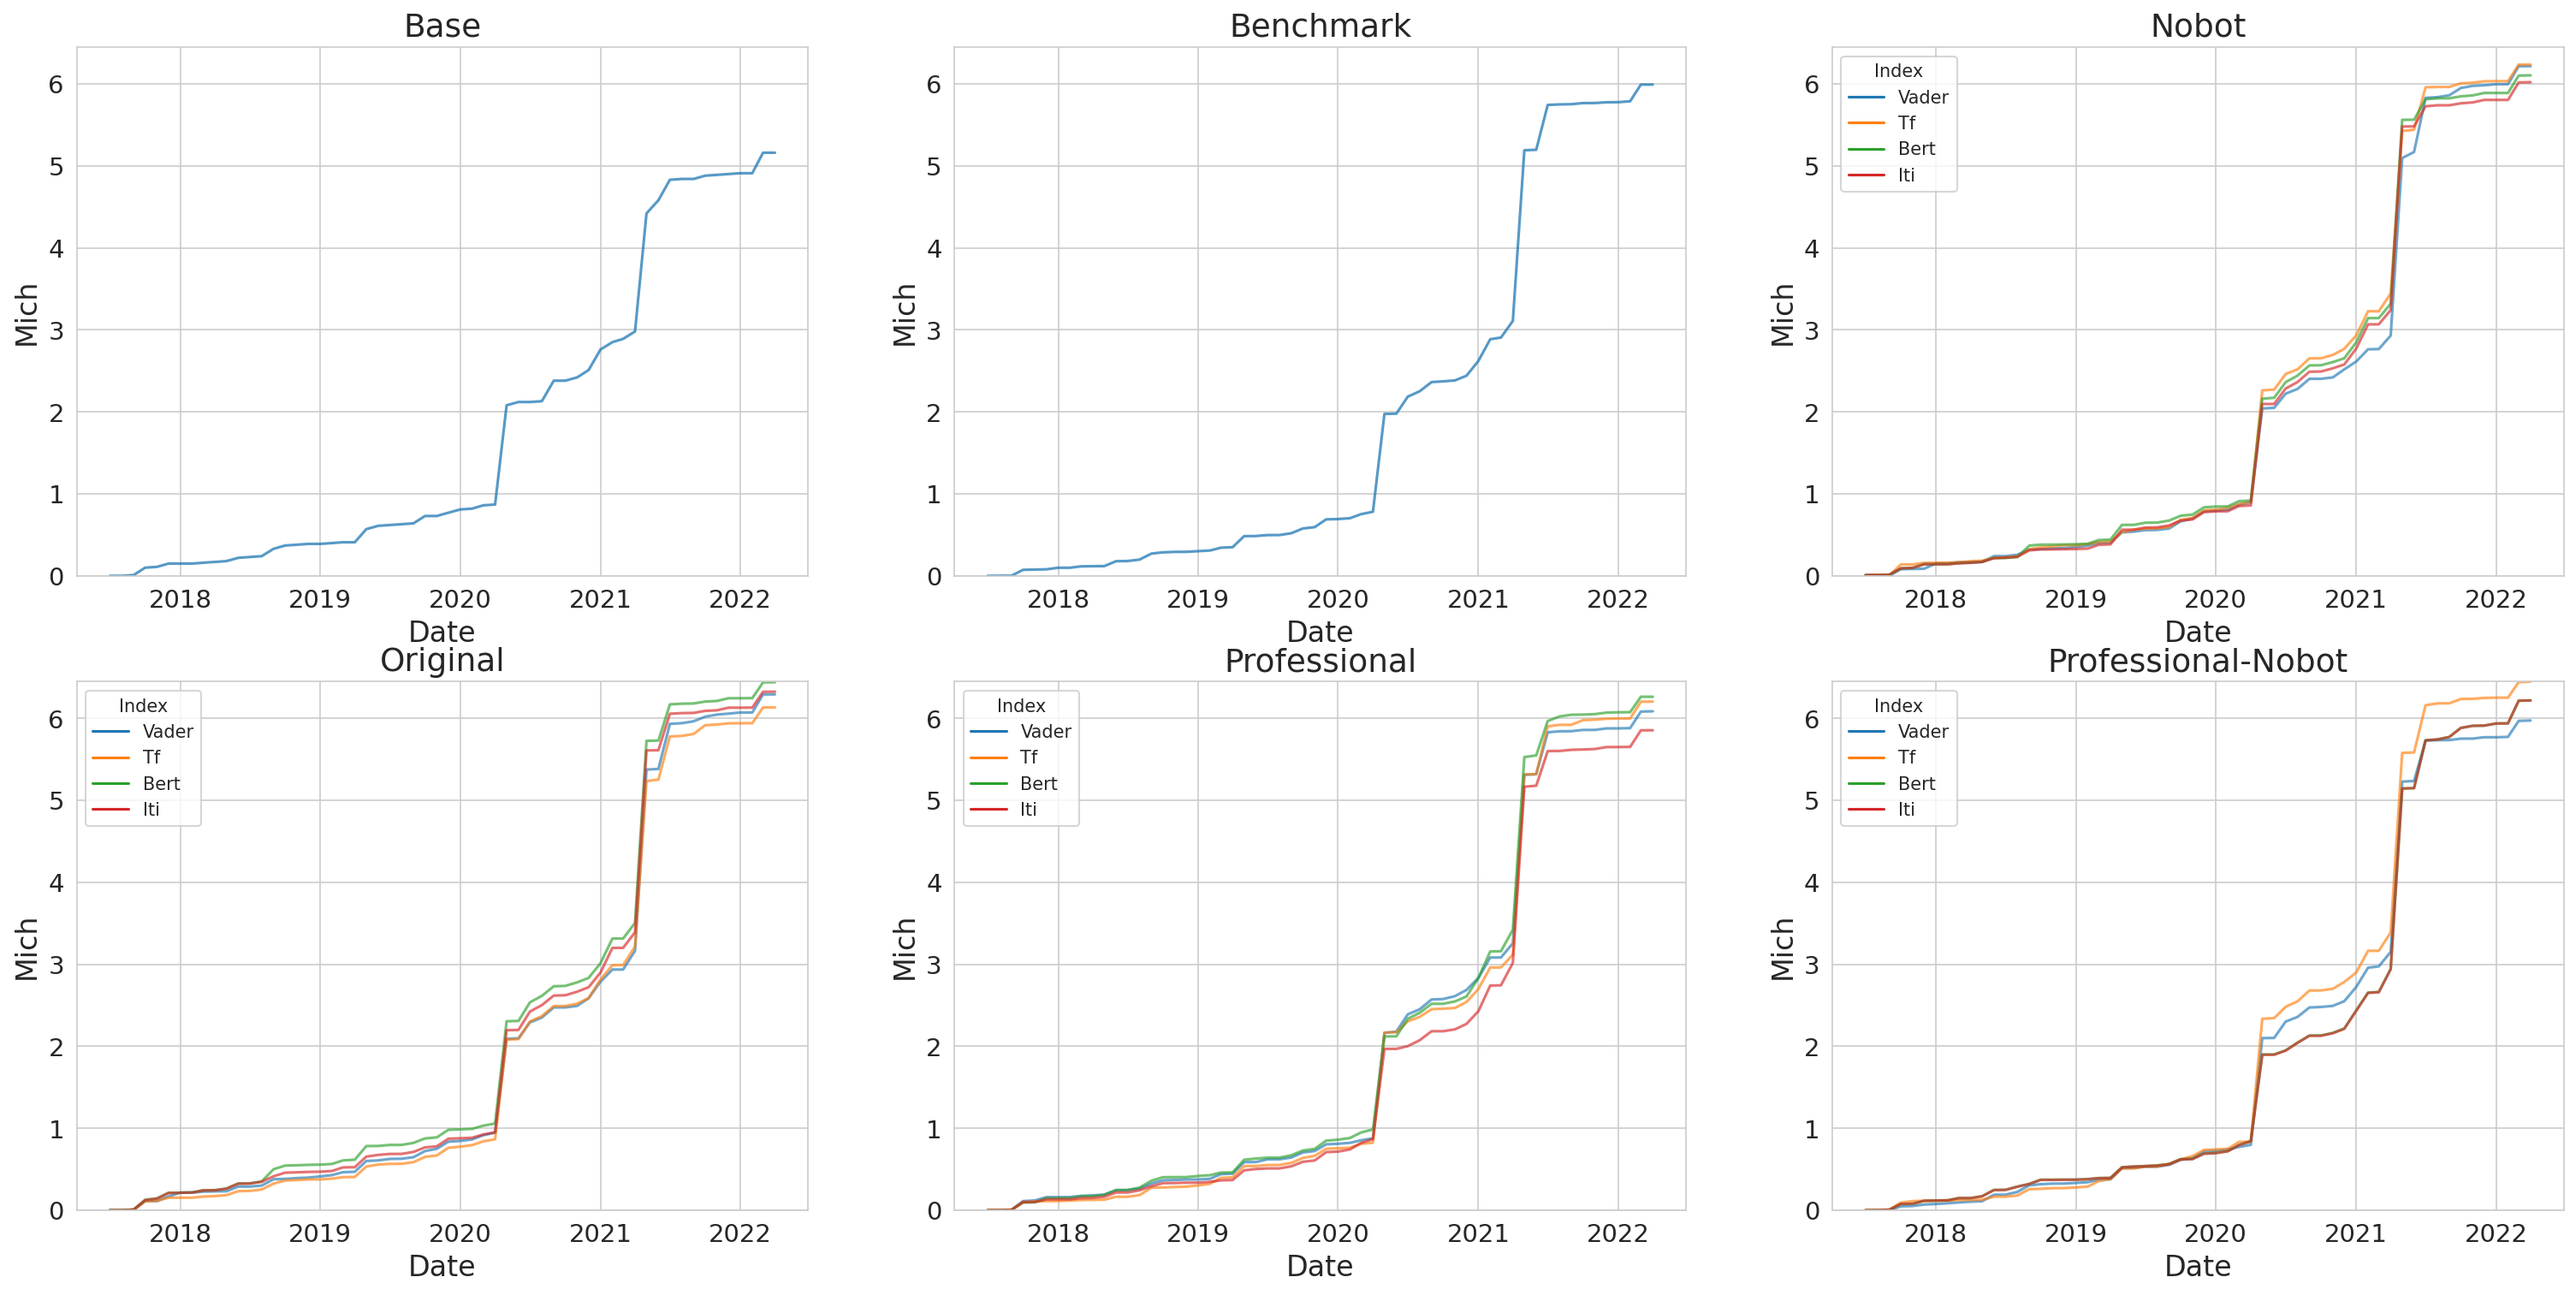

In [ ]:
inflation_measure = 'Mich'
fig, axs = plt.subplots(2, df_csfe_melted['Dataset'].nunique() // 2, figsize=(25, 12))
axs = axs.flatten()
max_cumulative_error = df_csfe_melted[df_csfe_melted['InflationMeasure'] == inflation_measure]['Value'].max()
for i, dataset in enumerate(df_csfe_melted.sort_values('Dataset')['Dataset'].unique()):
  axs[i].set_ylim(0, max_cumulative_error)
  axs[i].set_xlabel('Date', fontsize=16)
  axs[i].set_ylabel(inflation_measure, fontsize=16)
  axs[i].set_title(dataset, fontsize=18)
  if dataset == 'Base' or dataset == 'Benchmark':
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                   (df_csfe_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', ax=axs[i], alpha=.75)
  else:
    sns.lineplot(data=df_csfe_melted[(df_csfe_melted['InflationMeasure'] == inflation_measure) &
                                    (df_csfe_melted['Dataset'] == dataset)], 
                 x='DATE', y='Value', hue='Index', ax=axs[i], alpha=.65)

# Models Summary

In [ ]:
models['Professional-NoBot_ITI'].summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Aug, 2022
Time:                     17:00:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.10913
Nobs:                     104.000    HQIC:                  -9.29064
Log likelihood:           58.8323    FPE:                8.15627e-05
AIC:                     -9.41425    Det(Omega_mle):     7.28317e-05
--------------------------------------------------------------------
Results for equation INFLATION
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.314211         0.105158           -2.988           0.003
L1.INFLATION                      0.498709         0.093423            5.338           0.000
L1.MICH 

In [ ]:
models['Professional_ITI'].summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Aug, 2022
Time:                     17:00:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.05844
Nobs:                     103.000    HQIC:                  -9.37804
Log likelihood:           76.7224    FPE:                6.80689e-05
AIC:                     -9.59562    Det(Omega_mle):     5.58834e-05
--------------------------------------------------------------------
Results for equation INFLATION
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.330272         0.111113           -2.972           0.003
L1.INFLATION                0.614081         0.106211            5.782           0.000
L1.MICH                     0.16

In [ ]:
models['Professional-NoBot_Vader'].summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Aug, 2022
Time:                     17:00:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.74937
Nobs:                     102.000    HQIC:                  -9.20879
Log likelihood:           81.3973    FPE:                7.34045e-05
AIC:                     -9.52142    Det(Omega_mle):     5.54459e-05
--------------------------------------------------------------------
Results for equation INFLATION
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.328702         0.124300           -2.644           0.008
L1.INFLATION                        0.663823         0.111728            5.941           0.000
